# Lateral ventricle volume trajectories and response inhibition - class

Copyright (c) 2019, Arvid Lundervold

*Astri J. Lundervold, Alexandra Vik, Arvid Lundervold* <br>
**Lateral ventricle volume trajectories predict response inhibition in older age - a
longitudinal brain imaging and machine learning approach** <br>

**Objective:** In a three-wave 6 yrs longitudinal study we investigated if the expansion of lateral ventricle (LV) volumes (regarded as a proxy for brain tissue loss) predicts third wave performance on a test of response inhibition (RI).
**Participants and Methods:** Trajectories of left and right lateral ventricle volumes across the three waves were quantified using the longitudinal stream in Freesurfer. All participants (N=74;48 females;mean age 66.0 yrs at the third wave) performed the Color-Word Interference Test (CWIT). Response time on the third condition of CWIT, divided into fast, medium and slow, was used as outcome measure in a machine learning framework. Initially, we performed a linear mixed-effect (LME) analysis to describe subject-specific trajectories of the left and right LV volumes (LVV). These features were input to a multinomial logistic regression classification procedure, predicting individual belongings to one of the three RI classes. To obtain results that might generalize, we evaluated the significance of a k-fold cross-validated f1 score with a permutation test, providing a p-value that approximates the probability that the score would be obtained by chance. We also calculated a corresponding confusion matrix.
**Results:** The LME-model showed an annual ~3.0 % LVV increase. Evaluation of a cross-validated score using 500 permutations gave an f1-score of 0.462 that was above chance level (p=0.014). 56 % of the fast performers were successfully classified. All these were females, and typically older than 65 yrs at inclusion. For the true slow performers, those being correctly classified had higher LVVs than those being misclassified, and their ages at inclusion were also higher.
**Conclusion:** Major contributions were: (i) a longitudinal design, (ii) advanced brain imaging and segmentation procedures with longitudinal data analysis, and (iii) a data driven machine learning approach including cross-validation and permutation testing to predict behaviour, solely from the individual's brain ``signatures” (LVV trajectories).

The linear mixed effect model (LME) was fitted to the data, i.e.

$$\text{Vol}_{ij} = \beta_0 + \beta_1 \text{Age}_{ij} + (b_{0i} + b_{1i} \text{Age}_{ij}) + \epsilon_{ij}$$

Here, $\text{Vol}_{ij}$ the continuous *response variable* in the model is volume of left (right) latreral ventricle in subject $i$ ($i=1,\ldots,N$) at wave $j$ ($j=1,\ldots,n_i$). In our case we have $N=74$ and three wase with complete data, i.e. $n_i=3$ for all $i$. $\text{Age}_{ij}$ is age (in years) of subject $j$ at wave $j$, and a *predictor variable* in the model.

The model parameterrs $\beta_0$ and $\beta_1$ are *fixed effects* parameters.  The variables $b_{0i}$ and $b_{1i}$ 
($i=1,\ldots,N$) are the *random effects* parameters, assumed to be normally distributed witrh zero mean. They denote individual deviations in intercept ($b_{0i}$) and slope ($b_{1i}$), respectiveley, from the group-level fixed effect.
Finally, the random residual errors $\epsilon_{ij}$ are assumed to be independent and normally distributed (i.i.d) with zero mean and constant variance $\sigma_\epsilon^2$.

### Packages and libraries

See `setup.md` for setting up your system to run and modify `lvv-ri`<br>
Test your installation with `0.0-test.ipynb`

In [3]:
import os
import os.path as op
import sys
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import math
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot
from sklearn import tree
# import graphviz
# from distutils.sysconfig import get_python_lib
import sklearn
import matplotlib
import statsmodels
import rpy2
from rpy2.robjects import r, pandas2ri
pandas2ri.activate()
from rpy2.robjects.lib.tidyr import DataFrame

# Enable inline plotting
%matplotlib inline

In [4]:
print('Python version ' + sys.version)
# print(get_python_lib())
print('numpy: %s' % np.__version__)
print('pandas: %s' % pd.__version__)
print('scipy: %s' % scipy.__version__)
print('matplotlib: %s' % matplotlib.__version__)
print('sklearn: %s' % sklearn.__version__)
print('seaborn: %s' % sns.__version__)
print('statsmodels: %s' % statsmodels.__version__)
# print('graphviz: %s' % graphviz.__version__)
print('rpy2: %s' % rpy2.__version__)

Python version 3.7.2 (default, Dec 29 2018, 06:19:36) 
[GCC 7.3.0]
numpy: 1.16.2
pandas: 0.24.1
scipy: 1.2.1
matplotlib: 3.0.2
sklearn: 0.20.2
seaborn: 0.9.0
statsmodels: 0.9.0
rpy2: 2.9.1


In [5]:
eTIV_NORMALIZED = False

## Reading data

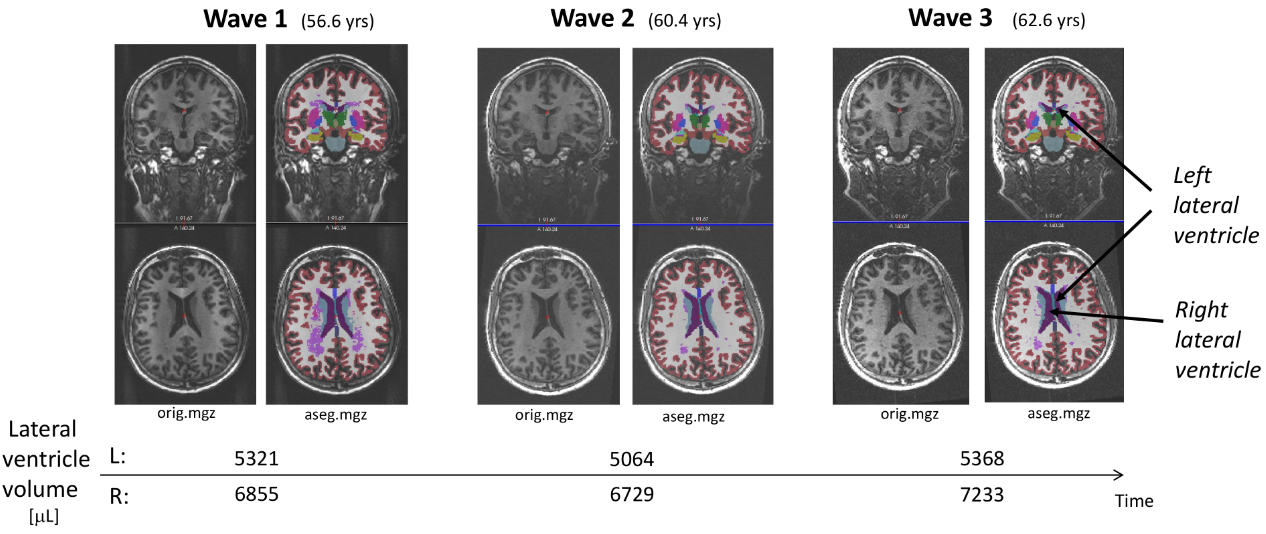

In [6]:
from IPython.display import Image
Image(filename='../assets/Figure1.png', width=800)

In [7]:
fn_data = '../data/lvv_ri_data.csv'
df = pd.read_csv(fn_data)

## Model-based (lmer) feature design

`02_lvv_ri_lda.ipynb`: <br>
"Fixed effects (left LV): beta0.L = -12057.62 ; beta1.L = 428.73"<br>
"Fixed effects (right LV): beta0.R = -11482.22 ; beta1.R = 408.61"<br>

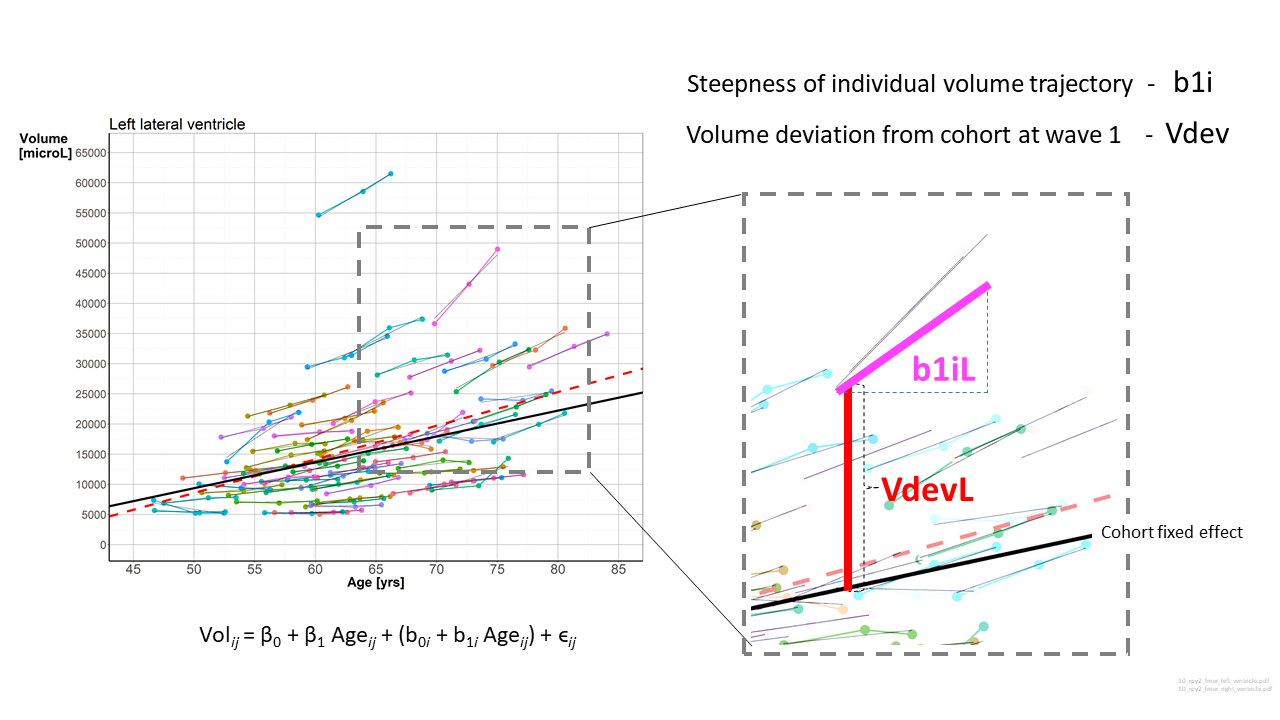

In [9]:
Image('../assets/Fig_2_LME_derived_features.png', width=900)

**Read and explore the fatures**

In [10]:
# Using lmer features from absolute ventricular volume measures
df = pd.read_csv('../results/03_lvv_ri_lmer_feature_data_label.csv')

# Using lmer features from eTIV-normalzed measures
#df = pd.read_csv('../results/03_lvv_ri_lmer_feature_data_label_eTIV_norm.csv')

In [11]:
df.head()

,id,Gender,Age3,b1iL,b1iR,VdevL,VdevR,RI3,RI3_label
0,1,F,62.62,-403.106006,-255.837480,-7043.921304,-5184.324848,66.0,slow
1,2,M,55.05,-192.279528,18.445213,2022.833808,1484.915004,85.0,slow
2,3,M,80.59,504.164116,431.948484,9742.140838,15864.793556,71.0,slow
3,4,M,62.68,242.654739,143.700117,9671.260622,3369.298064,41.0,fast
4,5,M,69.53,-535.067249,-119.315203,1969.929309,-1779.977513,62.0,slow


In [12]:
df.describe()

,id,Age3,b1iL,b1iR,VdevL,VdevR,RI3
count,74.000000,74.000000,7.400000e+01,7.400000e+01,74.000000,74.000000,74.000000
mean,37.500000,66.812568,1.703998e-09,-4.275902e-11,1002.706364,471.604509,56.986486
std,21.505813,7.185458,3.700545e+02,2.481606e+02,7791.572175,6761.078785,14.462510
min,1.000000,52.460000,-7.362918e+02,-3.403251e+02,-8928.731440,-9949.628573,35.000000
25%,19.250000,61.860000,-2.199263e+02,-1.706087e+02,-3813.773268,-3733.160830,46.000000
50%,37.500000,66.020000,-8.498361e+01,-7.213863e+01,-368.322111,-1481.083294,54.500000
75%,55.750000,72.092500,2.139539e+02,9.628106e+01,4047.003145,2662.220655,62.750000
max,74.000000,84.050000,1.605366e+03,8.468899e+02,40491.883497,26489.838179,102.000000


In [13]:
# Using labels from original RI (from Stroop_3) measurements 
classesRIcat = np.unique(df['RI3_label'])

In [14]:
n_classes = classesRIcat.size
print('The', n_classes, 'classesRIcat:', classesRIcat,'\n',df['RI3_label'].value_counts())

The 3 classesRIcat: ['fast' 'medium' 'slow'] 
 fast      25
slow      25
medium    24
Name: RI3_label, dtype: int64


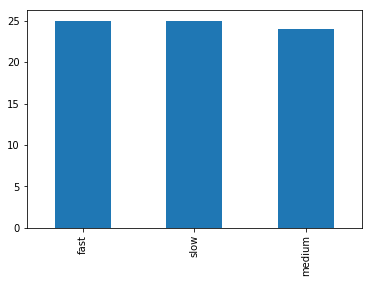

In [16]:
df['RI3_label'].value_counts().plot(kind='bar')
plt.show()

In [17]:
df.columns

Index(['id', 'Gender', 'Age3', 'b1iL', 'b1iR', 'VdevL', 'VdevR', 'RI3',
       'RI3_label'],
      dtype='object')

In [18]:
df.head(7)

,id,Gender,Age3,b1iL,b1iR,VdevL,VdevR,RI3,RI3_label
0,1,F,62.62,-403.106006,-255.837480,-7043.921304,-5184.324848,66.0,slow
1,2,M,55.05,-192.279528,18.445213,2022.833808,1484.915004,85.0,slow
2,3,M,80.59,504.164116,431.948484,9742.140838,15864.793556,71.0,slow
3,4,M,62.68,242.654739,143.700117,9671.260622,3369.298064,41.0,fast
4,5,M,69.53,-535.067249,-119.315203,1969.929309,-1779.977513,62.0,slow
5,6,F,66.82,300.564704,67.746034,1359.310993,418.523160,89.0,slow
6,7,M,64.87,-23.874878,-50.225546,6505.074307,-782.970461,46.0,fast


## What is X and y?

In [19]:
X = df.drop(['id', 'Gender', 'Age3', 'RI3', 'RI3_label'], axis=1)

yRIlab = df['RI3_label']

print(X.shape + yRIlab.shape)

(74, 4, 74)


In [20]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 4 columns):
b1iL     74 non-null float64
b1iR     74 non-null float64
VdevL    74 non-null float64
VdevR    74 non-null float64
dtypes: float64(4)
memory usage: 2.4 KB


In [21]:
X.head(5).T

,0,1,2,3,4
b1iL,-403.106006,-192.279528,504.164116,242.654739,-535.067249
b1iR,-255.837480,18.445213,431.948484,143.700117,-119.315203
VdevL,-7043.921304,2022.833808,9742.140838,9671.260622,1969.929309
VdevR,-5184.324848,1484.915004,15864.793556,3369.298064,-1779.977513


In [22]:
X.describe()

,b1iL,b1iR,VdevL,VdevR
count,7.400000e+01,7.400000e+01,74.000000,74.000000
mean,1.703998e-09,-4.275902e-11,1002.706364,471.604509
std,3.700545e+02,2.481606e+02,7791.572175,6761.078785
min,-7.362918e+02,-3.403251e+02,-8928.731440,-9949.628573
25%,-2.199263e+02,-1.706087e+02,-3813.773268,-3733.160830
50%,-8.498361e+01,-7.213863e+01,-368.322111,-1481.083294
75%,2.139539e+02,9.628106e+01,4047.003145,2662.220655
max,1.605366e+03,8.468899e+02,40491.883497,26489.838179


In [23]:
# Recode gender to numeric values F=0, M=1
gender_dic = {
    'F': 0,
    'M': 1
}
Xg = X.copy()
Xg['Gender'] = df['Gender'].map(gender_dic)
Xg.head().T

,0,1,2,3,4
b1iL,-403.106006,-192.279528,504.164116,242.654739,-535.067249
b1iR,-255.837480,18.445213,431.948484,143.700117,-119.315203
VdevL,-7043.921304,2022.833808,9742.140838,9671.260622,1969.929309
VdevR,-5184.324848,1484.915004,15864.793556,3369.298064,-1779.977513
Gender,0.000000,1.000000,1.000000,1.000000,1.000000


In [24]:
# Recode the RI labels to numeric values slow=0, medium=1, fast=2
RI_dic = {
    'slow':   0,
    'medium': 1,
    'fast':   2
}
yRIcat = pd.DataFrame()
yRIcat['RI'] = df['RI3_label'].map(RI_dic)
yRIcat.head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
RI,0,0,0,2,0,0,2,1,2,1,0,1,2,1,1,1,1,0,1,1


In [26]:
# Let X be numeric
#X = XX.copy()
X.shape

(74, 4)

In [27]:
yRIcat['RI'].values

array([0, 0, 0, 2, 0, 0, 2, 1, 2, 1, 0, 1, 2, 1, 1, 1, 1, 0, 1, 1, 2, 2,
       2, 2, 1, 0, 0, 2, 1, 1, 0, 0, 0, 0, 2, 2, 2, 1, 1, 1, 2, 2, 1, 1,
       1, 1, 2, 0, 0, 0, 0, 0, 1, 2, 0, 0, 2, 0, 1, 2, 0, 1, 0, 0, 1, 2,
       2, 2, 2, 2, 2, 2, 1, 0])

In [29]:
pd.DataFrame({'yRIcat': yRIcat['RI'].values, 'yRIlab': yRIlab}).head(15).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
yRIcat,0,0,0,2,0,0,2,1,2,1,0,1,2,1,1
yRIlab,slow,slow,slow,fast,slow,slow,fast,medium,fast,medium,slow,medium,fast,medium,medium


In [30]:
# Let y be numeric array
y = yRIcat.values.ravel()
y

array([0, 0, 0, 2, 0, 0, 2, 1, 2, 1, 0, 1, 2, 1, 1, 1, 1, 0, 1, 1, 2, 2,
       2, 2, 1, 0, 0, 2, 1, 1, 0, 0, 0, 0, 2, 2, 2, 1, 1, 1, 2, 2, 1, 1,
       1, 1, 2, 0, 0, 0, 0, 0, 1, 2, 0, 0, 2, 0, 1, 2, 0, 1, 0, 0, 1, 2,
       2, 2, 2, 2, 2, 2, 1, 0])

## Classification models

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import permutation_test_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

### Evaluate the significance of a cross-validated score with permutations

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.permutation_test_score.html

Learning the parameters of a prediction function and testing it on the same data is a methodological mistake: a model that would just repeat the labels of the samples that it has just seen would have a perfect score but would fail to predict anything useful on yet-unseen data. This situation is called **overfitting**. To avoid it, it is common practice when performing a (supervised) machine learning experiment to hold out part of the available data as a test set X_test, y_test.
However, by partitioning the available data into three sets (including a validation set for "hyperparameter" tuning), we drastically reduce the number of samples which can be used for learning the model, and the results can depend on a particular random choice for the pair of (train, validation) sets.

A solution to this problem is a procedure called **cross-validation** (CV for short). A test set should still be held out for final evaluation, but the validation set is no longer needed when doing CV. In the basic approach, called k-fold CV, the training set is split into *k* smaller sets. The following procedure is followed for each of the k “folds”:

 - A model is trained using *k-1* of the folds as training data;
 - the resulting model is validated on the remaining part of the data (i.e., it is used as a test set to compute a performance measure such as accuracy).
 
The performance measure reported by k-fold cross-validation is then the average of the values computed in the loop. This approach can be computationally expensive, but does not waste too much data (as is the case when fixing an arbitrary validation set), which is a major advantage in problems such as inverse inference where the number of samples is very small.

The simplest way to use cross-validation is to call the `cross_val_score` helper function on the estimator and the dataset.

By default, the score computed at each CV iteration is the score method of the estimator. It is possible to change this by using the scoring parameter.
In our dataset, the samples are balanced across target classes hence the accuracy and the F1-score are almost equal.

When the cv argument is an integer, cross_val_score uses the KFold or StratifiedKFold strategies by default, the latter being used if the estimator derives from ClassifierMixin.

Another option is to use an iterable yielding (train, test) splits as arrays of indices.

In order to test if a classification score is significative a technique in repeating the classification procedure after randomizing, permuting, the labels. The p-value is then given by the percentage of runs for which the score obtained is greater than the classification score obtained in the first place

https://github.com/scikit-learn/scikit-learn/issues/8379<br>
The permutation_test_score's p-value can be 0.0099 no matter what dataset/estimator is used. 
Actually this magic number is 1 / (n_permutations + 1) where n_permutations = 100 is the default for permutation_test_score. This corresponds to the case where the classifier is so good that none of the classifiers with shuffled labels has a better score.


Scoring: accuracy, f1_macro, f1_micro, samples, ... https://scikit-learn.org/stable/modules/model_evaluation.html

cv : int, cross-validation generator or an iterable

Determines the cross-validation splitting strategy. Possible inputs for cv are:

 - None, to use the default 3-fold cross validation,
 - integer, to specify the number of folds in a (Stratified)KFold,
 - CV splitter,
 - An iterable yielding (train, test) splits as arrays of indices.


In [33]:
rs = 42
k = 5
shuffle = False

In [34]:
cv = StratifiedKFold(k, random_state=rs, shuffle=shuffle)
cv

StratifiedKFold(n_splits=5, random_state=42, shuffle=False)

In [35]:
yRIlab.unique()

array(['slow', 'fast', 'medium'], dtype=object)

Classifications with k-fold CV (k=5, 10)<br>

**Data transformation with held out data**

Just as it is important to test a predictor on data held-out from training, preprocessing (such as standardization, feature selection, etc.) and similar data transformations similarly should be learnt from a training set and applied to held-out data for prediction. A Pipeline makes it easier to compose estimators, providing this behavior under cross-validation:

In [36]:
# Using Pipes - https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

**Scores for multi-class predictions** ('accuracy', 'f1_micro', ... )

The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:

F1 = 2 * (precision * recall) / (precision + recall)

In the multi-class and multi-label case, this is the average of the F1 score of each class with weighting depending on the average parameter

average : string, [None, ‘binary’ (default), ‘micro’, ‘macro’, ‘samples’, ‘weighted’]
This parameter is required for multiclass/multilabel targets. If None, the scores for each class are returned. Otherwise, this determines the type of averaging performed on the data:

'binary':
Only report results for the class specified by pos_label. This is applicable only if targets (y_{true,pred}) are binary.

'micro':
Calculate metrics globally by counting the total true positives, false negatives and false positives.

'macro':
Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.

'weighted':
Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.

'samples':
Calculate metrics for each instance, and find their average (only meaningful for multilabel classification where this differs from accuracy_score).

**The permutation_test_score( )**

REF: <br> Ojala and Garriga. *Permutation Tests for Studying Classifier Performance*. <br>
The Journal of Machine Learning Research (2010) vol. 11

Input:

 - **n_permutations** : integer
 Number of times to permute y.

Returns:

- **score** : float
The true score without permuting targets.<br>
- **permutation_scores** : array, shape (n_permutations,)
The scores obtained for each permutations.<br>
- **pvalue** : float
The p-value, which approximates the probability that the score would be obtained by chance. This is calculated as:<br>
(C + 1) / (n_permutations + 1), where C is the number of permutations whose score >= the true score.<br>
The best possible p-value is 1/(n_permutations + 1), the worst is 1.0.

**Logistic regression (multinomial)**

Each data point i (ranging from 1 to N=74) consists of a set of M=4 explanatory variables 
x1,i ... xM,i (aka independent variables, predictor variables, features, etc.), 
and an associated categorical outcome Yi (aka dependent variable, response variable), 
which can take on one of K=3 possible values. <br>
These possible values represent logically separate categories.

The goal of multinomial logistic regression is to construct a model that explains the
relationship between the explanatory variables and the outcome, so that the outcome of 
a new "experiment" can be correctly predicted for a new data point for which 
the explanatory variables, but not the outcome, are available. <br>
In the process, the model attempts to explain the relative effect of 
differing explanatory variables on the outcome.


scoring: f1_micro
X:  ['b1iL', 'b1iR', 'VdevL', 'VdevR']
y:  ['slow' 'fast' 'medium']
StratifiedKFold(n_splits=5, random_state=42, shuffle=False)
C: 0.500
LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=500, multi_class='multinomial',
          n_jobs=-1, penalty='l2', random_state=42, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)
logreg_scaler (C=0.50): Classification score (f1_micro) 0.4619 (pvalue : 0.014)


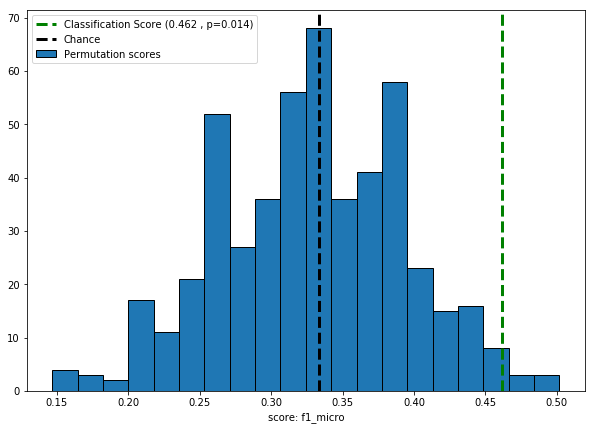

In [37]:
rs = 42                      # Random state
k = 5                        # k in k-fold CV
nperm = 500                  # Number of permutations
C = 0.5                      # Inverse of regularization strength
solver = 'lbfgs'             # Limited memory Broyden–Fletcher–Goldfarb–Shanno (BFGS) optimization
penalty = 'l2'               # Regularization penalty (L2)
multi_class = 'multinomial'  # Multinomial logreg  (or, 'auto')
shuffle = False

#scoring = ['accuracy', 'f1_micro']  # Scoring metrics
scoring = ['f1_micro']  # Scoring metric

for sc in scoring:
    
    print('\nscoring:', sc)
    
    print('X: ', list(X.columns))

    print('y: ', yRIlab.unique())

    cv = StratifiedKFold(k, random_state=rs, shuffle=shuffle); print(cv)

    # Inverse of regularization strength; must be a positive float. (0.3 Default: 1.0)
    # Like in support vector machines, smaller values specify stronger regularization.
    print('C: %.3f' % C)

    logreg = LogisticRegression(solver=solver, 
                                multi_class=multi_class, 
                                max_iter=500, 
                                penalty=penalty,
                                C=C, 
                                random_state=rs,
                                n_jobs=-1)

    print(logreg)

    logreg_pipe = Pipeline([('scaler', StandardScaler()), ('logreg', logreg)])


    logreg_scaler_score, logreg_scaler_permutation_scores, logreg_scaler_pvalue = permutation_test_score(
        logreg_pipe, 
        X, y, scoring=sc, cv=cv, n_permutations=nperm, n_jobs=-1, random_state=rs)

    print("logreg_scaler (C=%.2f): Classification score (%s) %s (pvalue : %s)" % 
          (C, sc, logreg_scaler_score.round(4), logreg_scaler_pvalue.round(4)))

    # View histogram of permutation scores (scaler)
    fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(10, 7) )
    plt.hist(logreg_scaler_permutation_scores, 20, label='Permutation scores',
             edgecolor='black')
    ylim = plt.ylim()

    plt.plot(2 * [logreg_scaler_score], ylim, '--g', linewidth=3,
             label='Classification Score'
             ' (%s , p=%s)' % (logreg_scaler_score.round(3), logreg_scaler_pvalue.round(3)))
    plt.plot(2 * [1. / n_classes], ylim, '--k', linewidth=3, label='Chance')

    plt.ylim(ylim)
    plt.legend(loc='upper left')
    plt.xlabel('score: %s' % sc)
    plt.show()

    figfn_pdf = '../figures/04_lvv_ri_logreg_scaler_%d_permutations_scores_%s.pdf' % (nperm, sc)
    figfn_png = '../figures/04_lvv_ri_logreg_scaler_%d_permutations_scores_%s.png' % (nperm, sc)
    fig.savefig(figfn_pdf, transparent=True)
    fig.savefig(figfn_png, transparent=True)

../figures/04_lvv_ri_logreg_scaler_500_permutations_scores_f1_micro.pdf


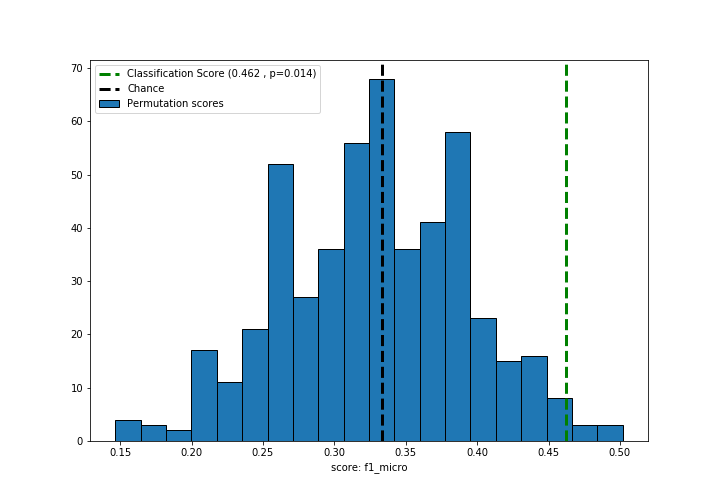

In [41]:
print(figfn_pdf)
Image('%s' % (figfn_png), width=900)

In [42]:
print('rs:', rs)
print('k in k-fold CV:', k)
print('nperm:', nperm)
print('C regularizer:', C)
print('logreg_scaler_pvalue:', logreg_scaler_pvalue.round(3))
print('N(logreg_scaler_permutation_scores): ', len(logreg_scaler_permutation_scores))
print('mean(logreg_scaler_permutation_scores): ', np.mean(logreg_scaler_permutation_scores).round(3))
print('SD(logreg_scaler_permutation_scores): ', np.std(logreg_scaler_permutation_scores).round(3))
print('Observed logreg_scaler_score: ', logreg_scaler_score.round(3))

rs: 42
k in k-fold CV: 5
nperm: 500
C regularizer: 0.5
logreg_scaler_pvalue: 0.014
N(logreg_scaler_permutation_scores):  500
mean(logreg_scaler_permutation_scores):  0.329
SD(logreg_scaler_permutation_scores):  0.065
Observed logreg_scaler_score:  0.462


**Obtaining predictions by cross-validation**<br>
https://scikit-learn.org/stable/modules/cross_validation.html <br>
https://stackoverflow.com/questions/49587820/getting-the-confusion-matrix-for-each-cross-validation-fold

The function cross_val_predict has a similar interface to cross_val_score, but returns, for each element in the input, the prediction that was obtained for that element when it was in the test set. Only cross-validation strategies that assign all elements to a test set exactly once can be used (otherwise, an exception is raised).

_Warning Note on inappropriate usage of cross_val_predict_<br>
The result of cross_val_predict may be different from those obtained using cross_val_score as the elements are grouped in different ways. The function cross_val_score takes an average over cross-validation folds, whereas cross_val_predict simply returns the labels (or probabilities) from several distinct models undistinguished. Thus, cross_val_predict is not an appropriate measure of generalisation error.

The function `cross_val_predic`t is appropriate for:
 - Visualization of predictions obtained from different models.
 - Model blending: When predictions of one supervised estimator are used to train another estimator in ensemble methods.


https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html#sklearn.model_selection.cross_val_predict

**Cross val score**

Return array of scores of the estimator for each run of the cross validation.

In [43]:
this_scores = cross_val_score(logreg_pipe, X, y, cv=cv, n_jobs=1, scoring='f1_micro')
print('mean cross_val_score: %.4f (SD %.4f)' % (np.mean(this_scores).round(4), np.std(this_scores).round(4)))

mean cross_val_score: 0.4619 (SD 0.1332)


Evaluate metric(s) by cross-validation and also record fit/score times.

In [44]:
cv_results = cross_validate(logreg_pipe, X, y, cv=cv, 
                            scoring=['accuracy', 'f1_micro'], 
                            return_train_score=False)

In [45]:
cv_results

{'fit_time': array([0.00999641, 0.00899863, 0.00600648, 0.00499797, 0.00500083]),
 'score_time': array([0.0009985 , 0.00199962, 0.00100088, 0.00099969, 0.00100136]),
 'test_accuracy': array([0.4       , 0.33333333, 0.33333333, 0.6       , 0.64285714]),
 'test_f1_micro': array([0.4       , 0.33333333, 0.33333333, 0.6       , 0.64285714])}

In [46]:
np.mean(cv_results['test_f1_micro']).round(4)

0.4619

**Cross val predict**

Get predictions from each split of cross-validation for diagnostic purposes. Generate cross-validated estimates for each input data point.<br>
It is not appropriate to pass these predictions into an evaluation metric. Use cross_validate to measure generalization error.

The reported averages include micro average (averaging the total true positives, false negatives and false positives), macro average (averaging the unweighted mean per label), weighted average (averaging the support-weighted mean per label) and sample average (only for multilabel classification).

Note that in binary classification, recall of the positive class is also known as “sensitivity”; recall of the negative class is “specificity”.

Compute precision, recall, F-measure and support for each class

The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0.

The F-beta score weights recall more than precision by a factor of beta. beta == 1.0 means recall and precision are equally important.

The support is the number of occurrences of each class in y_true.

If pos_label is None and in binary classification, this function returns the average precision, recall and F-measure if average is one of 'micro', 'macro', 'weighted' or 'samples'.

In [47]:
method = 'predict'  # 'predict', 'predict_proba'
y_pred = cross_val_predict(logreg_pipe, X, y, cv=cv, method=method)
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.45      0.40      0.43        25
           1       0.50      0.42      0.45        24
           2       0.44      0.56      0.49        25

   micro avg       0.46      0.46      0.46        74
   macro avg       0.46      0.46      0.46        74
weighted avg       0.46      0.46      0.46        74



In [48]:
report = classification_report(y, y_pred,  digits=2, labels = [0, 1, 2], target_names = ['slow', 'medium', 'fast'], output_dict=True)
df_report = pd.DataFrame(report).transpose().round(4)
df_report

,f1-score,precision,recall,support
slow,0.4255,0.4545,0.4000,25.0
medium,0.4545,0.5000,0.4167,24.0
fast,0.4912,0.4375,0.5600,25.0
micro avg,0.4595,0.4595,0.4595,74.0
macro avg,0.4571,0.4640,0.4589,74.0
weighted avg,0.4571,0.4635,0.4595,74.0


In [49]:
print(df_report.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  f1-score &  precision &  recall &  support \\
\midrule
slow         &    0.4255 &     0.4545 &  0.4000 &     25.0 \\
medium       &    0.4545 &     0.5000 &  0.4167 &     24.0 \\
fast         &    0.4912 &     0.4375 &  0.5600 &     25.0 \\
micro avg    &    0.4595 &     0.4595 &  0.4595 &     74.0 \\
macro avg    &    0.4571 &     0.4640 &  0.4589 &     74.0 \\
weighted avg &    0.4571 &     0.4635 &  0.4595 &     74.0 \\
\bottomrule
\end{tabular}



In [50]:
y_pred = cross_val_predict(logreg_pipe, X, y, cv=cv, method=method)
print('y_pred, \ny_true')
y_pred, y

y_pred, 
y_true


(array([2, 1, 0, 1, 1, 0, 1, 2, 0, 1, 2, 2, 0, 1, 1, 1, 2, 2, 0, 2, 2, 2,
        2, 0, 0, 0, 0, 0, 1, 2, 2, 2, 1, 2, 1, 1, 1, 0, 0, 1, 2, 2, 1, 1,
        1, 2, 0, 1, 0, 0, 1, 2, 2, 2, 2, 0, 0, 2, 0, 2, 0, 1, 0, 0, 0, 2,
        2, 2, 2, 2, 2, 2, 2, 2], dtype=int64),
 array([0, 0, 0, 2, 0, 0, 2, 1, 2, 1, 0, 1, 2, 1, 1, 1, 1, 0, 1, 1, 2, 2,
        2, 2, 1, 0, 0, 2, 1, 1, 0, 0, 0, 0, 2, 2, 2, 1, 1, 1, 2, 2, 1, 1,
        1, 1, 2, 0, 0, 0, 0, 0, 1, 2, 0, 0, 2, 0, 1, 2, 0, 1, 0, 0, 1, 2,
        2, 2, 2, 2, 2, 2, 1, 0], dtype=int64))

In [51]:
# cm = sklearn.metrics.confusion_matrix(y, y_pred, labels=['slow', 'medium', 'fast'])
cm = sklearn.metrics.confusion_matrix(y, y_pred)
cm

array([[10,  5, 10],
       [ 6, 10,  8],
       [ 6,  5, 14]], dtype=int64)

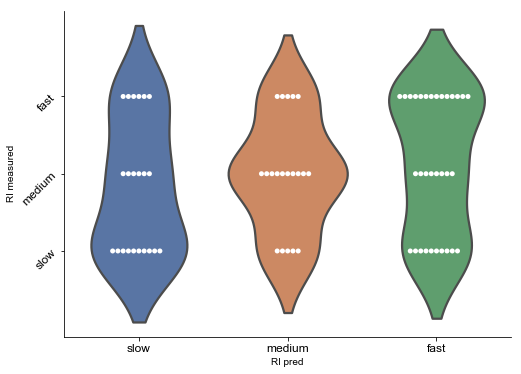

In [52]:
import seaborn as sns

cm = sklearn.metrics.confusion_matrix(y, y_pred)

fig, ax = plt.subplots(1,1, figsize=(8,6))

sns.set(style='ticks', context='talk')

xlabels = ['slow','medium','fast']
ylabels = ['slow','medium','fast']
#ylabels = ['fast','medium','slow']

preds = pd.DataFrame({'RI measured': y, 'RI pred': y_pred})
#preds = pd.DataFrame({'RI measured': 2-y, 'RI pred': y_pred})

ax = sns.swarmplot('RI pred', 'RI measured', data=preds, color = "white")
ax = sns.violinplot(x='RI pred', y='RI measured', data=preds, inner=None)
plt.xticks(range(0,len(xlabels)),xlabels,rotation=0, fontsize=12)
plt.yticks(range(0,len(ylabels)),ylabels,rotation=45, fontsize=12)
#ax.plot([0, 1], [0, 1], transform=ax.transAxes)
sns.despine()
#sns.heatmap(np.flipud(cm), annot=True)
figfn_cm_pdf = '../figures/04_lvv_ri_log_reg_scaler_confusion_matrix_swarmplot_violinplot.pdf'
fig.savefig(figfn_cm_pdf, transparent=True)

In [53]:
from pandas_ml import ConfusionMatrix

# Recode the RI labels to numeric values slow=0, medium=1, fast=2
RI_inv_dic = {
    0:   'slow',
    1:   'medium',
    2:   'fast'
}
y_label = pd.DataFrame({'y_lab': y})
y_label['y_label'] = y_label['y_lab'].map(RI_inv_dic)

y_pred_label = pd.DataFrame({'y_pred_lab': y_pred})
y_label['y_pred_label'] = y_pred_label['y_pred_lab'].map(RI_inv_dic)

y_label.head(15).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
y_lab,0,0,0,2,0,0,2,1,2,1,0,1,2,1,1
y_label,slow,slow,slow,fast,slow,slow,fast,medium,fast,medium,slow,medium,fast,medium,medium
y_pred_label,fast,medium,slow,medium,medium,slow,medium,fast,slow,medium,fast,fast,slow,medium,medium


In [54]:
# https://pandas-ml.readthedocs.io/en/latest/conf_mat.html
yy_true = ['rabbit', 'cat', 'rabbit', 'rabbit', 'cat', 'dog', 'dog', 'rabbit', 'rabbit', 'cat', 'dog', 'rabbit']
yy_pred = ['cat', 'cat', 'rabbit', 'dog', 'cat', 'rabbit', 'dog', 'cat', 'rabbit', 'cat', 'rabbit', 'rabbit']
yy_confusion_matrix = ConfusionMatrix(yy_true, yy_pred)
print("yy Confusion matrix:\n%s" % yy_confusion_matrix)

yy Confusion matrix:
Predicted  cat  dog  rabbit  __all__
Actual                              
cat          3    0       0        3
dog          0    1       2        3
rabbit       2    1       3        6
__all__      5    2       5       12


In [55]:
y_label['y_label'].values

array(['slow', 'slow', 'slow', 'fast', 'slow', 'slow', 'fast', 'medium',
       'fast', 'medium', 'slow', 'medium', 'fast', 'medium', 'medium',
       'medium', 'medium', 'slow', 'medium', 'medium', 'fast', 'fast',
       'fast', 'fast', 'medium', 'slow', 'slow', 'fast', 'medium',
       'medium', 'slow', 'slow', 'slow', 'slow', 'fast', 'fast', 'fast',
       'medium', 'medium', 'medium', 'fast', 'fast', 'medium', 'medium',
       'medium', 'medium', 'fast', 'slow', 'slow', 'slow', 'slow', 'slow',
       'medium', 'fast', 'slow', 'slow', 'fast', 'slow', 'medium', 'fast',
       'slow', 'medium', 'slow', 'slow', 'medium', 'fast', 'fast', 'fast',
       'fast', 'fast', 'fast', 'fast', 'medium', 'slow'], dtype=object)

In [56]:
y_label['y_pred_label'].values

array(['fast', 'medium', 'slow', 'medium', 'medium', 'slow', 'medium',
       'fast', 'slow', 'medium', 'fast', 'fast', 'slow', 'medium',
       'medium', 'medium', 'fast', 'fast', 'slow', 'fast', 'fast', 'fast',
       'fast', 'slow', 'slow', 'slow', 'slow', 'slow', 'medium', 'fast',
       'fast', 'fast', 'medium', 'fast', 'medium', 'medium', 'medium',
       'slow', 'slow', 'medium', 'fast', 'fast', 'medium', 'medium',
       'medium', 'fast', 'slow', 'medium', 'slow', 'slow', 'medium',
       'fast', 'fast', 'fast', 'fast', 'slow', 'slow', 'fast', 'slow',
       'fast', 'slow', 'medium', 'slow', 'slow', 'slow', 'fast', 'fast',
       'fast', 'fast', 'fast', 'fast', 'fast', 'fast', 'fast'],
      dtype=object)

In [57]:
confusion_matrix = ConfusionMatrix(y_label['y_label'].values, y_label['y_pred_label'].values)
print("Confusion matrix:\n%s" % confusion_matrix)

Confusion matrix:
Predicted  fast  medium  slow  __all__
Actual                                
fast         14       5     6       25
medium        8      10     6       24
slow         10       5    10       25
__all__      32      20    22       74


In [58]:
def cm2df(cm, labels):
    _df = pd.DataFrame()
    # rows
    for i, row_label in enumerate(labels):
        rowdata={}
        # columns
        for j, col_label in enumerate(labels): 
            rowdata[col_label]=cm[i,j]
        _df = _df.append(pd.DataFrame.from_dict({row_label:rowdata}, orient='index'))
    return _df[labels]

cmdf = cm2df(cm, xlabels)
print(cmdf)
print(cmdf.to_latex())

        slow  medium  fast
slow      10       5    10
medium     6      10     8
fast       6       5    14
\begin{tabular}{lrrr}
\toprule
{} &  slow &  medium &  fast \\
\midrule
slow   &    10 &       5 &    10 \\
medium &     6 &      10 &     8 \\
fast   &     6 &       5 &    14 \\
\bottomrule
\end{tabular}



In [59]:
confusion_matrix.print_stats()

Confusion Matrix:

Predicted  fast  medium  slow  __all__
Actual                                
fast         14       5     6       25
medium        8      10     6       24
slow         10       5    10       25
__all__      32      20    22       74


Overall Statistics:

Accuracy: 0.4594594594594595
95% CI: (0.3429195917062334, 0.5793443273251775)
No Information Rate: ToDo
P-Value [Acc > NIR]: 0.3608177987401836
Kappa: 0.18815139879319806
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                                    fast    medium      slow
Population                                   74        74        74
P: Condition positive                        25        24        25
N: Condition negative                        49        50        49
Test outcome positive                        32        20        22
Test outcome negative                        42        54        52
TP: True Positive                            14        10        10
TN: True Negative          

C:\Users\arvid\Anaconda3\lib\site-packages\pandas_ml\confusion_matrix\stats.py:60: FutureWarning: supplying multiple axes to axis is deprecated and will be removed in a future version.
  num = df[df > 1].dropna(axis=[0, 1], thresh=1).applymap(lambda n: choose(n, 2)).sum().sum() - np.float64(nis2 * njs2) / n2


In [60]:
confusion_matrix.stats()

OrderedDict([('cm', Predicted  fast  medium  slow  __all__
              Actual                                
              fast         14       5     6       25
              medium        8      10     6       24
              slow         10       5    10       25
              __all__      32      20    22       74),
             ('overall',
              OrderedDict([('Accuracy', 0.4594594594594595),
                           ('95% CI',
                            (0.3429195917062334, 0.5793443273251775)),
                           ('No Information Rate', 'ToDo'),
                           ('P-Value [Acc > NIR]', 0.3608177987401836),
                           ('Kappa', 0.18815139879319806),
                           ("Mcnemar's Test P-Value", 'ToDo')])),
             ('class',
              Classes                                    fast    medium      slow
              Population                                   74        74        74
              P: Condition positive

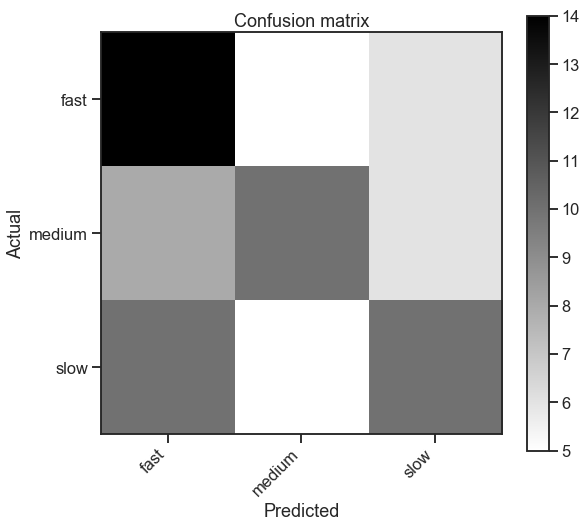

In [61]:
confusion_matrix.plot()
plt.show()

In [62]:
#cm = confusion_matrix(y, y_pred)
#print(np.flipud(cm))
#xlabels = ['slow','medium','fast']
#ylabels = ['slow','medium','fast']
#
#ax = sns.heatmap(cm, square=True, linewidth=0.5, cmap="gray")
#plt.xticks(range(0,len(xlabels)),xlabels,rotation=0, fontsize=12)
#plt.yticks(range(0,len(ylabels)),ylabels,rotation=45, fontsize=12)
#
#plt.show()

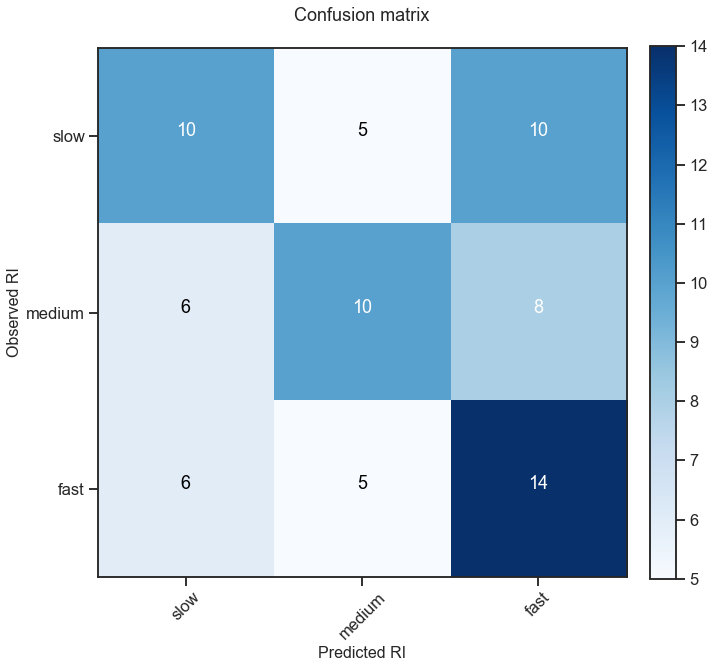

In [63]:
from utils import plot_confusion_matrix, plot_confusion_matrix_with_colorbar
cm = sklearn.metrics.confusion_matrix(y, y_pred)
classes = ['slow', 'medium', 'fast'] 


plot_confusion_matrix_with_colorbar(cm, classes=classes, 
                                    title='Confusion matrix\n',
#                                    cmap='gray',
                                    figsize=(10,10))
plt.ylabel('Observed RI')
plt.xlabel('Predicted RI')
fn_cm_pdf = '../figures/04_lvv_ri_log_reg_scaler_confusion_matrix.pdf'
plt.savefig(fn_cm_pdf, transparent=True)

plt.show()


In [64]:
y_label.head()

,y_lab,y_label,y_pred_label
0,0,slow,fast
1,0,slow,medium
2,0,slow,slow
3,2,fast,medium
4,0,slow,medium


In [65]:
df.head()

,id,Gender,Age3,b1iL,b1iR,VdevL,VdevR,RI3,RI3_label,RI3resid,RI3resid_label
0,1,F,62.62,-403.143034,-342.561962,-7043.602048,-4203.292419,66.0,slow,7.076375,slow_resid
1,2,M,55.05,-192.310801,-155.450942,2023.174773,2955.526208,85.0,slow,10.015983,slow_resid
2,3,M,80.59,504.247682,649.658359,9741.998107,15582.024184,71.0,slow,10.971306,slow_resid
3,4,M,62.68,242.649643,83.657769,9671.495552,4323.033064,41.0,fast,-4.390219,medium_resid
4,5,M,69.53,-535.182165,-450.127330,1970.509513,-11.193543,62.0,slow,-3.008883,medium_resid


In [66]:
pd_df_longL = pd.read_csv('../results/02_lvv_ri_left_long_data.csv')

In [67]:
pd_df_LVV = pd.read_csv('../data/01_lvv_ri_renamed_data.csv')
pd_df_LVV.head(2)

,subj,gender,yrW1,yrW2,yrW3,left_lvvW1,left_lvvW2,left_lvvW3,right_lvvW1,right_lvvW2,right_lvvW3,eTIV,RI
0,subj_01,F,56.63,60.35,62.62,5321.4,5063.6,5368.3,6855.2,6729.2,7233.2,1.232679e+06,66.0
1,subj_02,M,49.07,52.58,55.05,11038.6,11912.2,12313.3,10611.6,11774.8,12070.5,1.464692e+06,85.0


In [68]:
pd_df_LVV.tail(2)

,subj,gender,yrW1,yrW2,yrW3,left_lvvW1,left_lvvW2,left_lvvW3,right_lvvW1,right_lvvW2,right_lvvW3,eTIV,RI
72,subj_73,M,64.94,68.06,70.72,13761.7,14458.4,15401.0,10104.5,10634.4,11892.1,1.345172e+06,55.0
73,subj_74,M,65.65,68.77,70.83,16031.6,16899.5,18750.6,13703.9,14620.6,16278.6,1.584154e+06,74.0


In [69]:
dfCM = pd.DataFrame({'id': df['id'].values,
                    'Gender': df['Gender'].values,
                    'Age1': pd_df_longL[pd_df_longL['Wave']==1].Age.values,
                    'Age3': df['Age3'].values,
                    'b1iL': df['b1iL'].values,
                    'b1iR': df['b1iR'].values,
                    'VdevL': df['VdevL'].values,
                    'VdevR': df['VdevR'].values,
                    'y_obs': y_label['y_label'].values,
                    'y_pred': y_label['y_pred_label'].values,
                    'LVV1L': pd_df_LVV['left_lvvW1'].values,
                    'LVV1R': pd_df_LVV['right_lvvW1'].values,                    
                    'LVV3L': pd_df_LVV['left_lvvW3'].values,
                    'LVV3R': pd_df_LVV['right_lvvW3'].values,
                    'eTIV': pd_df_LVV['eTIV'].values
                    })
dfCM.head()

,id,Gender,Age1,Age3,b1iL,b1iR,VdevL,VdevR,y_obs,y_pred,LVV1L,LVV1R,LVV3L,LVV3R,eTIV
0,1,F,56.63,62.62,-403.143034,-342.561962,-7043.602048,-4203.292419,slow,fast,5321.4,6855.2,5368.3,7233.2,1.232679e+06
1,2,M,49.07,55.05,-192.310801,-155.450942,2023.174773,2955.526208,slow,medium,11038.6,10611.6,12313.3,12070.5,1.464692e+06
2,3,M,74.61,80.59,504.247682,649.658359,9741.998107,15582.024184,slow,slow,29718.4,34241.0,35887.0,41221.4,1.385841e+06
3,4,M,56.23,62.68,242.649643,83.657769,9671.495552,4323.033064,fast,medium,21830.1,15243.9,26164.2,18509.1,1.529445e+06
4,5,M,63.22,69.53,-535.182165,-450.127330,1970.509513,-11.193543,slow,medium,17205.1,13962.1,15858.1,13143.9,1.371460e+06


In [70]:
dfCM.tail()

,id,Gender,Age1,Age3,b1iL,b1iR,VdevL,VdevR,y_obs,y_pred,LVV1L,LVV1R,LVV3L,LVV3R,eTIV
69,70,F,55.80,62.40,165.449791,54.725890,-1752.969152,-1130.422482,fast,fast,10058.9,9376.7,14126.2,12632.4,1.311282e+06
70,71,F,67.80,73.00,-90.624222,-263.127981,-8166.960764,-9560.757179,fast,fast,8583.8,5876.8,10581.4,6973.0,1.061528e+06
71,72,F,66.40,71.59,-172.436880,-184.614297,-7840.009267,-6996.234514,fast,fast,8472.6,7858.1,9906.5,9297.7,1.241762e+06
72,73,M,64.94,70.72,-133.188755,-134.465637,-2119.894185,-4400.169246,medium,fast,13761.7,10104.5,15401.0,11892.1,1.345172e+06
73,74,M,65.65,70.83,58.713629,26.940855,-207.149360,-1105.397428,slow,fast,16031.6,13703.9,18750.6,16278.6,1.584154e+06


In [71]:
dfCM.describe().round(3)

,id,Age1,Age3,b1iL,b1iR,VdevL,VdevR,LVV1L,LVV1R,LVV3L,LVV3R,eTIV
count,74.000,74.000,74.000,74.000,74.000,74.000,74.000,74.000,74.000,74.000,74.000,74.000
mean,37.500,60.748,66.813,-0.000,-0.000,1002.897,1126.014,14994.097,13777.277,17605.222,16381.115,1360709.407
std,21.506,7.255,7.185,370.107,357.155,7791.545,6663.462,8584.677,7743.447,10354.047,9646.087,151345.899
min,1.000,46.660,52.460,-736.382,-478.806,-8928.976,-9560.757,5303.100,4408.300,5235.000,3810.200,1053942.809
25%,19.250,55.612,61.860,-219.940,-236.860,-3813.564,-3051.282,9193.000,8394.150,11127.525,9615.975,1246747.069
50%,37.500,59.875,66.020,-84.964,-96.857,-368.292,-338.838,12259.600,12181.850,14225.500,13732.200,1372028.983
75%,55.750,66.393,72.092,213.988,81.325,4047.246,3809.644,17726.725,16178.800,21889.850,19299.300,1447931.052
max,74.000,77.630,84.050,1605.733,1575.213,40492.323,25026.265,54646.700,40721.300,61501.400,52859.400,1766114.254


In [74]:
IncL = 429*100 / 14994
IncR = 426*100 / 13777
print('Yearly in crease in LVV left hemisphere: %.2f %%' % (IncL))
print('Yearly in crease in LVV right hemisphere: %.2f %%' % (IncR))

Yearly in crease in LVV left hemisphere: 2.86 %
Yearly in crease in LVV right hemisphere: 3.09 %


In [102]:
Age1T = 65
Age3T = 65
myclasses = ['slow', 'medium', 'fast']
myclassesno = [0, 1, 2]
myCM = np.zeros((3,3), dtype=int)
myF = np.zeros((3,3), dtype=int)
myM = np.zeros((3,3), dtype=int)
myA1 = np.zeros((3,3), dtype=int)
myA3 = np.zeros((3,3), dtype=int)

my_b1iL = [ [ [],[],[] ], [ [],[],[] ], [ [],[],[] ] ]
my_b1iR = [ [ [],[],[] ], [ [],[],[] ], [ [],[],[] ] ]
my_LVV3L = [ [ [],[],[] ], [ [],[],[] ], [ [],[],[] ] ]
my_LVV3R = [ [ [],[],[] ], [ [],[],[] ], [ [],[],[] ] ]
for o in range(len(myclasses)):
    for p in range(len(myclasses)):
        my_b1iL[o][p] = []
        my_b1iR[o][p] = []
        my_LVV3L[o][p] = []
        my_LVV3R[o][p] = []
        
for i in range(dfCM.shape[0]):
    for o in range(len(myclasses)):
        for p in range(len(myclasses)):
            if (dfCM['y_obs'][i] == myclasses[o]) &  (dfCM['y_pred'][i] == myclasses[p]):
                myCM[o][p] =  myCM[o][p]+1
                if dfCM['Gender'][i] == 'F':
                    myF[o][p] =  myF[o][p]+1
                else:
                    myM[o][p] =  myM[o][p]+1
                if dfCM['Age1'][i] > Age1T:
                    myA1[o][p] = myA1[o][p] +1
                if dfCM['Age3'][i] > Age3T:
                    myA3[o][p] = myA3[o][p] +1
                my_b1iL[o][p].append(dfCM['b1iL'][i])
                my_b1iR[o][p].append(dfCM['b1iR'][i])
                my_LVV3L[o][p].append(dfCM['LVV3L'][i])
                my_LVV3R[o][p].append(dfCM['LVV3R'][i])

In [103]:
print('Confusion matrix (observed,predicted):\n', myCM)

Confusion matrix (observed,predicted):
 [[10  5 10]
 [ 6 10  8]
 [ 6  5 14]]


In [104]:
print('Female occurences (observed,predicted):\n', myF)

Female occurences (observed,predicted):
 [[ 6  2  7]
 [ 3  6  5]
 [ 2  3 14]]


In [105]:
print('Male occurences (observed,predicted):\n', myM)

Male occurences (observed,predicted):
 [[4 3 3]
 [3 4 3]
 [4 2 0]]


In [106]:
print('Age1 > Age1T=%d occurences (observed,predicted):\n' % Age1T, myA1)

Age1 > Age1T=65 occurences (observed,predicted):
 [[8 1 3]
 [3 0 2]
 [0 1 5]]


In [107]:
print('Age3 > Age3T=%d occurences (observed,predicted):\n' % Age3T, myA3)

Age3 > Age3T=65 occurences (observed,predicted):
 [[9 3 8]
 [5 2 5]
 [2 1 8]]


In [108]:
for o in range(len(myclasses)):
    for p in range(len(myclasses)):
        print('my_LVV3L[%d][%d] = %s' % (o, p,  my_LVV3L[o][p]))
        # plt.hist(my_LVV3L[o][p])
        # plt.title('LVV3L[%d][%d] n=%d, mean=%.1f' % (o,p, len(my_LVV3L[o][p]), np.mean(my_LVV3L[o][p])))
        # plt.show()
        print('LVV3L[%d][%d] n=%d, mean=%.1f' % (o,p, len(my_LVV3L[o][p]), np.mean(my_LVV3L[o][p])))

my_LVV3L[0][0] = [35887.0, 19464.2, 24895.0, 32342.1, 33276.7, 25486.1, 21190.3, 21927.7, 49001.3, 32220.1]
LVV3L[0][0] n=10, mean=29569.0
my_LVV3L[0][1] = [12313.3, 15858.1, 10832.9, 34579.9, 17533.6]
LVV3L[0][1] n=5, mean=18223.6
my_LVV3L[0][2] = [5368.3, 11525.0, 7936.3, 14324.8, 7670.5, 11440.2, 13070.9, 20510.0, 11154.0, 18750.6]
LVV3L[0][2] n=10, mean=12175.1
my_LVV3L[1][0] = [17854.8, 13891.4, 21589.9, 21806.0, 34951.1, 25146.9]
LVV3L[1][0] n=6, mean=22540.0
my_LVV3L[1][1] = [13901.2, 15543.0, 24815.7, 16728.5, 13516.2, 37374.4, 61501.4, 9141.0, 5235.0, 18774.2]
LVV3L[1][1] n=10, mean=21653.1
my_LVV3L[1][2] = [12915.2, 7970.1, 9934.6, 9458.0, 10028.7, 11118.7, 13450.5, 15401.0]
LVV3L[1][2] n=8, mean=11284.6
my_LVV3L[2][0] = [23556.7, 14584.4, 17531.3, 15917.8, 21917.8, 12979.9]
LVV3L[2][0] n=6, mean=17748.0
my_LVV3L[2][1] = [26164.2, 22141.1, 31420.1, 5464.7, 7826.0]
LVV3L[2][1] n=5, mean=18603.2
my_LVV3L[2][2] = [12536.5, 7268.1, 13604.0, 12168.3, 5464.2, 6603.2, 11254.3, 5713.

In [109]:
for o in range(len(myclasses)):
    for p in range(len(myclasses)):
        print('my_LVV3R[%d][%d] = %s' % (o, p,  my_LVV3R[o][p]))
        # plt.hist(my_LVV3R[o][p])
        # plt.title('LVV3R[%d][%d] n=%d, mean=%.1f' % (o,p, len(my_LVV3R[o][p]), np.mean(my_LVV3R[o][p])))
        # plt.show()
        print('LVV3R[%d][%d] n=%d, mean=%.1f' % (o,p, len(my_LVV3R[o][p]), np.mean(my_LVV3R[o][p])))

my_LVV3R[0][0] = [41221.4, 17163.3, 32457.2, 34304.9, 31812.1, 27756.3, 23696.2, 30908.7, 52859.4, 30465.0]
LVV3R[0][0] n=10, mean=32264.5
my_LVV3R[0][1] = [12070.5, 13143.9, 9395.1, 29003.3, 15853.4]
LVV3R[0][1] n=5, mean=15893.2
my_LVV3R[0][2] = [7233.2, 13035.3, 10836.6, 14323.7, 7157.6, 9138.5, 9509.7, 18505.4, 7359.1, 16278.6]
LVV3R[0][2] n=10, mean=11337.8
my_LVV3R[1][0] = [16491.3, 16175.3, 19997.0, 23593.8, 31927.2, 27993.7]
LVV3R[1][0] n=6, mean=22696.4
my_LVV3R[1][1] = [11690.9, 11556.4, 19667.3, 14530.2, 10752.1, 23754.5, 42271.7, 7681.6, 3810.2, 14056.4]
LVV3R[1][1] n=10, mean=15977.1
my_LVV3R[1][2] = [12308.5, 7799.9, 8435.2, 10028.5, 7887.8, 13056.1, 13812.7, 11892.1]
LVV3R[1][2] n=8, mean=10652.6
my_LVV3R[2][0] = [26889.3, 15211.3, 17135.4, 16747.4, 19400.7, 14863.0]
LVV3R[2][0] n=6, mean=18374.5
my_LVV3R[2][1] = [18509.1, 13651.7, 18995.1, 6221.9, 7388.2]
LVV3R[2][1] n=5, mean=12953.2
my_LVV3R[2][2] = [14551.3, 9291.5, 14146.1, 9934.8, 5100.4, 6916.1, 10314.5, 6918.1, 1

In [110]:
for o in range(len(myclasses)):
    for p in range(len(myclasses)):
        print('my_b1iL[%d][%d] = %s' % (o, p,  my_b1iL[o][p]))
        # plt.hist(my_b1iL[o][p])
        # plt.title('b1iL[%d][%d] n=%d, mean=%.1f' % (o,p, len(my_b1iL[o][p]), np.mean(my_b1iL[o][p])))
        # plt.show()

my_b1iL[0][0] = [504.2476821889196, 300.6063203200339, 245.79599910137927, 633.5116878418072, 328.1972361560077, -136.1570128296285, 135.71743360641057, 423.6880696677945, 1605.7329410539887, 339.78892239930275]
my_b1iL[0][1] = [-192.31080108246968, -535.1821649721721, -339.23612335503867, 352.9513427635948, -478.7448202197053]
my_b1iL[0][2] = [-403.143033868349, -78.5220432812584, -165.88012378130082, 229.10867776115487, -277.0319929581983, -79.30365140728462, 156.0178725482815, 92.21740409532735, -7.58417565894888, 58.713629012252035]
my_b1iL[1][0] = [18.014524350345, -110.13585687447471, 222.42550517395088, 263.90751556834, 379.19305725277, 347.5555789271956]
my_b1iL[1][1] = [-168.91962254577555, 14.137984341643744, 134.59766176976336, -175.9413244818291, -136.82396123703893, 581.8449545266734, 785.7883377652988, -532.2667044209938, -736.3823588054172, -263.03765588548595]
my_b1iL[1][2] = [-270.2367850247331, -254.16149150865087, -217.83922664864795, -200.16844506568333, -181.366733

### Permutation importance

Compared to most other approaches, **permutation importance** is:

 - Fast to calculate
 - Widely used and understood
 - Consistent with properties we would want a feature importance measure to have
 
 https://www.kaggle.com/dansbecker/permutation-importance
 
Randomly re-ordering a single column should cause less accurate predictions, since the resulting data no longer corresponds to anything observed in the real world. Model accuracy especially suffers if we shuffle a column that the model relied on heavily for predictions.

With this insight, the process is as follows:

 1. Get a trained model
 2. Shuffle the values in a single column, make predictions using the resulting dataset. Use these predictions and the true target values to calculate how much the loss function suffered from shuffling. That performance deterioration measures the importance of the variable you just shuffled.
 3. Return the data to the original order (undoing the shuffle from step 2.) Now repeat step 2 with the next column in the dataset, until you have calculated the importance of each column.

**Interpreting Permutation Importances**

The values towards the top are the most important features, and those towards the bottom matter least.

The first number in each row shows how much model performance decreased with a random shuffling (in this case, using "accuracy" as the performance metric).

Like most things in data science, there is some randomness to the exact performance change from a shuffling a column. We measure the amount of randomness in our permutation importance calculation by repeating the process with multiple shuffles. The number after the ± measures how performance varied from one-reshuffling to the next.

You'll occasionally see negative values for permutation importances. In those cases, the predictions on the shuffled (or noisy) data happened to be more accurate than the real data. This happens when the feature didn't matter (should have had an importance close to 0), but random chance caused the predictions on shuffled data to be more accurate. This is more common with small datasets, like the one in this example, because there is more room for luck/chance.

In [111]:
import eli5
from eli5.sklearn import PermutationImportance

**Permutation importance with standard scaler**

In [112]:
logreg_pipe.fit(X, y)
perm_pipe = PermutationImportance(logreg_pipe, scoring='f1_micro', n_iter=50, random_state=rs, cv=cv)

In [113]:
perm_pipe

PermutationImportance(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=False),
           estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logreg', LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=500, multi_class='multinomial',
          n_jobs=-1, penalty='l2', random_state=42, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))]),
           n_iter=50, random_state=42, refit=True, scoring='f1_micro')

In [114]:
perm_pipe.fit(X, y)

PermutationImportance(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=False),
           estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logreg', LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=500, multi_class='multinomial',
          n_jobs=-1, penalty='l2', random_state=42, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))]),
           n_iter=50, random_state=42, refit=True, scoring='f1_micro')

In [115]:
#perm_pipe.predict(X)

In [116]:
#y

In [117]:
#perm_confusion_matrix = ConfusionMatrix(y, perm_pipe.predict(X))

In [118]:
#perm_confusion_matrix.classification_report

In [119]:
#perm_confusion_matrix.print_stats()

In [120]:
perm_pipe.feature_importances_

array([0.01544762, 0.10622857, 0.07481905, 0.10611429])

In [121]:
perm_pipe.feature_importances_std_

array([0.0685146 , 0.10896557, 0.10512546, 0.11882144])

In [122]:
eli5.show_weights(perm_pipe, feature_names = X.columns.tolist())

Weight,Feature
0.1062 ± 0.2179,b1iR
0.1061 ± 0.2376,VdevR
0.0748 ± 0.2103,VdevL
0.0154 ± 0.1370,b1iL


**Permutation importance without vs. with a standard scaler**

In [123]:
logreg.fit(X, y)
perm = PermutationImportance(logreg, scoring='f1_micro', n_iter=100, random_state=rs).fit(X, y)
eli5.show_weights(perm, feature_names = X.columns.tolist())

Weight,Feature
0.0930 ± 0.0885,VdevR
0.0828 ± 0.0867,VdevL
0.0431 ± 0.0795,b1iR
0.0186 ± 0.0695,b1iL


In [124]:
logreg_pipe.fit(X, y)
perm = PermutationImportance(logreg_pipe, scoring='f1_micro', n_iter=100, random_state=rs).fit(X, y)
eli5.show_weights(perm, feature_names = X.columns.tolist())

Weight,Feature
0.0658 ± 0.0870,VdevL
0.0570 ± 0.0898,VdevR
0.0477 ± 0.0783,b1iR
-0.0073 ± 0.0548,b1iL


### Spaghetti plot in R of LVV trajectories labelled with y=RI3 ('fast', 'medium', 'slow') and predicted y_pred

In [125]:
# Read the long formated data to the present repository as .csv
if eTIV_NORMALIZED:
    pd_df_longL = pd.read_csv('../results/02_lvv_ri_left_long_data_eTIV_norm.csv')
    pd_df_longR = pd.read_csv('../results/02_lvv_ri_right_long_data_eTIV_norm.csv')
else:
    pd_df_longL = pd.read_csv('../results/02_lvv_ri_left_long_data.csv')
    pd_df_longR = pd.read_csv('../results/02_lvv_ri_right_long_data.csv')

In [126]:
pd_df_longL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222 entries, 0 to 221
Data columns (total 5 columns):
subj      222 non-null int64
Region    222 non-null object
Wave      222 non-null int64
Age       222 non-null float64
Volume    222 non-null float64
dtypes: float64(2), int64(2), object(1)
memory usage: 8.8+ KB


In [127]:
pd_df_longL.head(7).T

,0,1,2,3,4,5,6
subj,1,1,1,2,2,2,3
Region,LeftLateralVentricle,LeftLateralVentricle,LeftLateralVentricle,LeftLateralVentricle,LeftLateralVentricle,LeftLateralVentricle,LeftLateralVentricle
Wave,1,2,3,1,2,3,1
Age,56.63,60.35,62.62,49.07,52.58,55.05,74.61
Volume,5321.4,5063.6,5368.3,11038.6,11912.2,12313.3,29718.4


In [128]:
pd_df_longR.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222 entries, 0 to 221
Data columns (total 5 columns):
subj      222 non-null int64
Region    222 non-null object
Wave      222 non-null int64
Age       222 non-null float64
Volume    222 non-null float64
dtypes: float64(2), int64(2), object(1)
memory usage: 8.8+ KB


In [129]:
# Read the longitudinal Wave Age Volume Subject RI3_label for LEFT and RIGHT hemsipheres
if eTIV_NORMALIZED:
    dfL = pd.read_csv('../results/03_lvv_ri_LH_longitudinal_label_eTIV_norm.csv')
    dfR = pd.read_csv('../results/03_lvv_ri_RH_longitudinal_label_eTIV_norm.csv')
else:
    dfL = pd.read_csv('../results/03_lvv_ri_LH_longitudinal_label.csv')
    dfR = pd.read_csv('../results/03_lvv_ri_RH_longitudinal_label.csv')

In [130]:
dfL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222 entries, 0 to 221
Data columns (total 5 columns):
Wave         222 non-null int64
Age          222 non-null float64
Volume       222 non-null float64
Subject      222 non-null int64
RI3_label    222 non-null object
dtypes: float64(2), int64(2), object(1)
memory usage: 8.8+ KB


In [131]:
dfR.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222 entries, 0 to 221
Data columns (total 5 columns):
Wave         222 non-null int64
Age          222 non-null float64
Volume       222 non-null float64
Subject      222 non-null int64
RI3_label    222 non-null object
dtypes: float64(2), int64(2), object(1)
memory usage: 8.8+ KB


In [132]:
dfL.head(15).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Wave,1,2,3,1,2,3,1,2,3,1,2,3,1,2,3
Age,56.63,60.35,62.62,49.07,52.58,55.05,74.61,78.14,80.59,56.23,59.78,62.68,63.22,67,69.53
Volume,5321.4,5063.6,5368.3,11038.6,11912.2,12313.3,29718.4,32265.1,35887,21830.1,23933.6,26164.2,17205.1,16970.1,15858.1
Subject,1,1,1,2,2,2,3,3,3,4,4,4,5,5,5
RI3_label,slow,slow,slow,slow,slow,slow,slow,slow,slow,fast,fast,fast,slow,slow,slow


In [133]:
df.head()

,id,Gender,Age3,b1iL,b1iR,VdevL,VdevR,RI3,RI3_label,RI3resid,RI3resid_label
0,1,F,62.62,-403.143034,-342.561962,-7043.602048,-4203.292419,66.0,slow,7.076375,slow_resid
1,2,M,55.05,-192.310801,-155.450942,2023.174773,2955.526208,85.0,slow,10.015983,slow_resid
2,3,M,80.59,504.247682,649.658359,9741.998107,15582.024184,71.0,slow,10.971306,slow_resid
3,4,M,62.68,242.649643,83.657769,9671.495552,4323.033064,41.0,fast,-4.390219,medium_resid
4,5,M,69.53,-535.182165,-450.127330,1970.509513,-11.193543,62.0,slow,-3.008883,medium_resid


In [134]:
dg = pd.DataFrame({'Subject': df['id'].values, 
                   'Gender': df['Gender'].values, 
                   'RI_obs': y_label['y_label'].values,
                   'RI_pred': y_label['y_pred_label'].values})

In [135]:
dfLg = pd.merge(dg, dfL.copy(), on = 'Subject', how = 'left')
dfLg.head(15).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Subject,1,1,1,2,2,2,3,3,3,4,4,4,5,5,5
Gender,F,F,F,M,M,M,M,M,M,M,M,M,M,M,M
RI_obs,slow,slow,slow,slow,slow,slow,slow,slow,slow,fast,fast,fast,slow,slow,slow
RI_pred,fast,fast,fast,medium,medium,medium,slow,slow,slow,medium,medium,medium,medium,medium,medium
Wave,1,2,3,1,2,3,1,2,3,1,2,3,1,2,3
Age,56.63,60.35,62.62,49.07,52.58,55.05,74.61,78.14,80.59,56.23,59.78,62.68,63.22,67,69.53
Volume,5321.4,5063.6,5368.3,11038.6,11912.2,12313.3,29718.4,32265.1,35887,21830.1,23933.6,26164.2,17205.1,16970.1,15858.1
RI3_label,slow,slow,slow,slow,slow,slow,slow,slow,slow,fast,fast,fast,slow,slow,slow


In [136]:
dfRg = pd.merge(dg, dfR.copy(), on = 'Subject', how = 'left')
dfRg.head(15).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Subject,1,1,1,2,2,2,3,3,3,4,4,4,5,5,5
Gender,F,F,F,M,M,M,M,M,M,M,M,M,M,M,M
RI_obs,slow,slow,slow,slow,slow,slow,slow,slow,slow,fast,fast,fast,slow,slow,slow
RI_pred,fast,fast,fast,medium,medium,medium,slow,slow,slow,medium,medium,medium,medium,medium,medium
Wave,1,2,3,1,2,3,1,2,3,1,2,3,1,2,3
Age,56.63,60.35,62.62,49.07,52.58,55.05,74.61,78.14,80.59,56.23,59.78,62.68,63.22,67,69.53
Volume,6855.2,6729.2,7233.2,10611.6,11774.8,12070.5,34241,37155.2,41221.4,15243.9,16505.1,18509.1,13962.1,13755.5,13143.9
RI3_label,slow,slow,slow,slow,slow,slow,slow,slow,slow,fast,fast,fast,slow,slow,slow


**R graphics (ggplot2)**

In [137]:
%reload_ext rpy2.ipython

In [138]:
from rpy2.robjects import r, pandas2ri
pandas2ri.activate()

In [139]:
import warnings
warnings.filterwarnings('ignore')

In [140]:
from rpy2.robjects.packages import importr
utils = importr('utils')
# If needed to install - uncomment the following
#utils.install_packages('tidyr')
#utils.install_packages('lme4')
#utils.install_packages('caret')
#utils.install_packages('tidyverse')
#utils.install_packages('devtools')
#utils.install_packages('rlang')
#utils.install_packages('Rccp')
#utils.install_packages('GGally')
#utils.install_packages('tikzDevice')
#utils.install_packages('stargazer')
#utils.install_packages('readxl')
#utils.install_packages('ggplot2')
#utils.install_packages('stringi')

In [141]:
%R R.version$system

array(['x86_64, mingw32'], dtype='<U15')

In [142]:
%R R.version$version.string

array(['R version 3.5.1 (2018-07-02)'], dtype='<U28')

In [143]:
%R library(rlang); library(Rcpp); library(stargazer); library(readxl); library(ggplot2); library(GGally)

array(['GGally', 'ggplot2', 'readxl', 'stargazer', 'Rcpp', 'rlang',
       'lazyeval', 'dplyr', 'tidyr', 'tools', 'RevoUtils', 'stats',
       'graphics', 'grDevices', 'utils', 'datasets', 'RevoUtilsMath',
       'methods', 'base'], dtype='<U13')

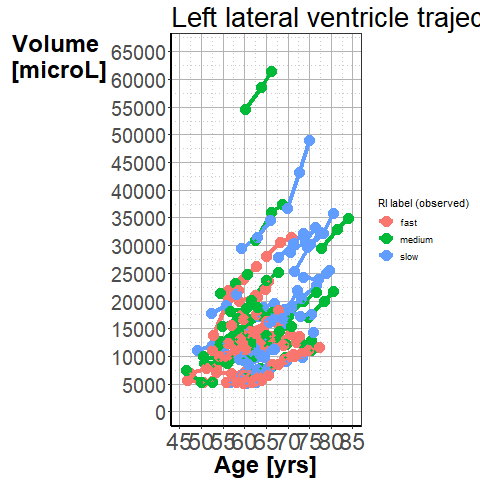

In [144]:
%%R -i dfLg -i eTIV_NORMALIZED

NOR <- eTIV_NORMALIZED

# Left lateral ventricle

if (NOR) {
title.1.L <- "Left lateral ventricle (eTIV normalized)"
} else {
RdfLg <-  dfLg

title.1.L <- "Left lateral ventricle trajectories - color-coded by observed RI class"

mytitle <- title.1.L

g11 <- ggplot(data = RdfLg, aes(x = Age, y = Volume, group = Subject, colour = factor(RI_obs))) + geom_line(size=1.5)
g11 <- g11 + scale_colour_discrete(name  ="RI label (observed)") + geom_point(pch=19, size = 5)
myX <- scale_x_continuous(limits = c(45, 85), breaks = seq(45, 85, 5), name = "Age [yrs]")
myY <- scale_y_continuous(limits = c(500, 65000), breaks = seq(0, 65000, 5000), name = "Volume\n [microL]") 

g11 <- g11 + geom_point(size = 1.0) + theme_bw() + myX + myY
g11 <- g11 + labs(title = mytitle, fontsize = 32)
# Set title to twice the base font size
g11 <- g11 + theme(plot.title = element_text(size = rel(2.0)))
g11 <- g11 + theme(axis.line = element_line(size = 1, colour = "black", linetype = "solid"))
g11 <- g11 + theme(axis.text = element_text(size = rel(1.5)))
g11 <- g11 + theme(axis.title.y = element_text(size = rel(1.8), angle = 0))
g11 <- g11 + theme(axis.title.x = element_text(size = rel(1.8), angle = 0))
g11 <- g11 + theme(panel.grid.major = element_line(colour = "gray70"))
g11 <- g11 + theme(panel.grid.minor = element_line(colour = "gray80", linetype = "dotted"))
g11 <- g11 + theme(plot.background = element_rect(fill = "white"))

g11 <- g11 + theme(axis.text.x=element_text(size=24), axis.title.x=element_text(size=24,face="bold"))
g11 <- g11 + theme(axis.text.y=element_text(size=20), axis.title.y=element_text(size=24,face="bold"))
g11 <- g11 + theme(plot.title = element_text(size=28))

print(g11)
    
ggsave("../figures/04_lvv_ri_rpy2_LH_by_RI_obs.pdf", width = 40, height = 30, units = "cm")
ggsave("../figures/04_lvv_ri_rpy2_LH_by_RI_obs.png", width = 40, height = 30, units = "cm")
}

In [145]:
%R str(RdfLg)

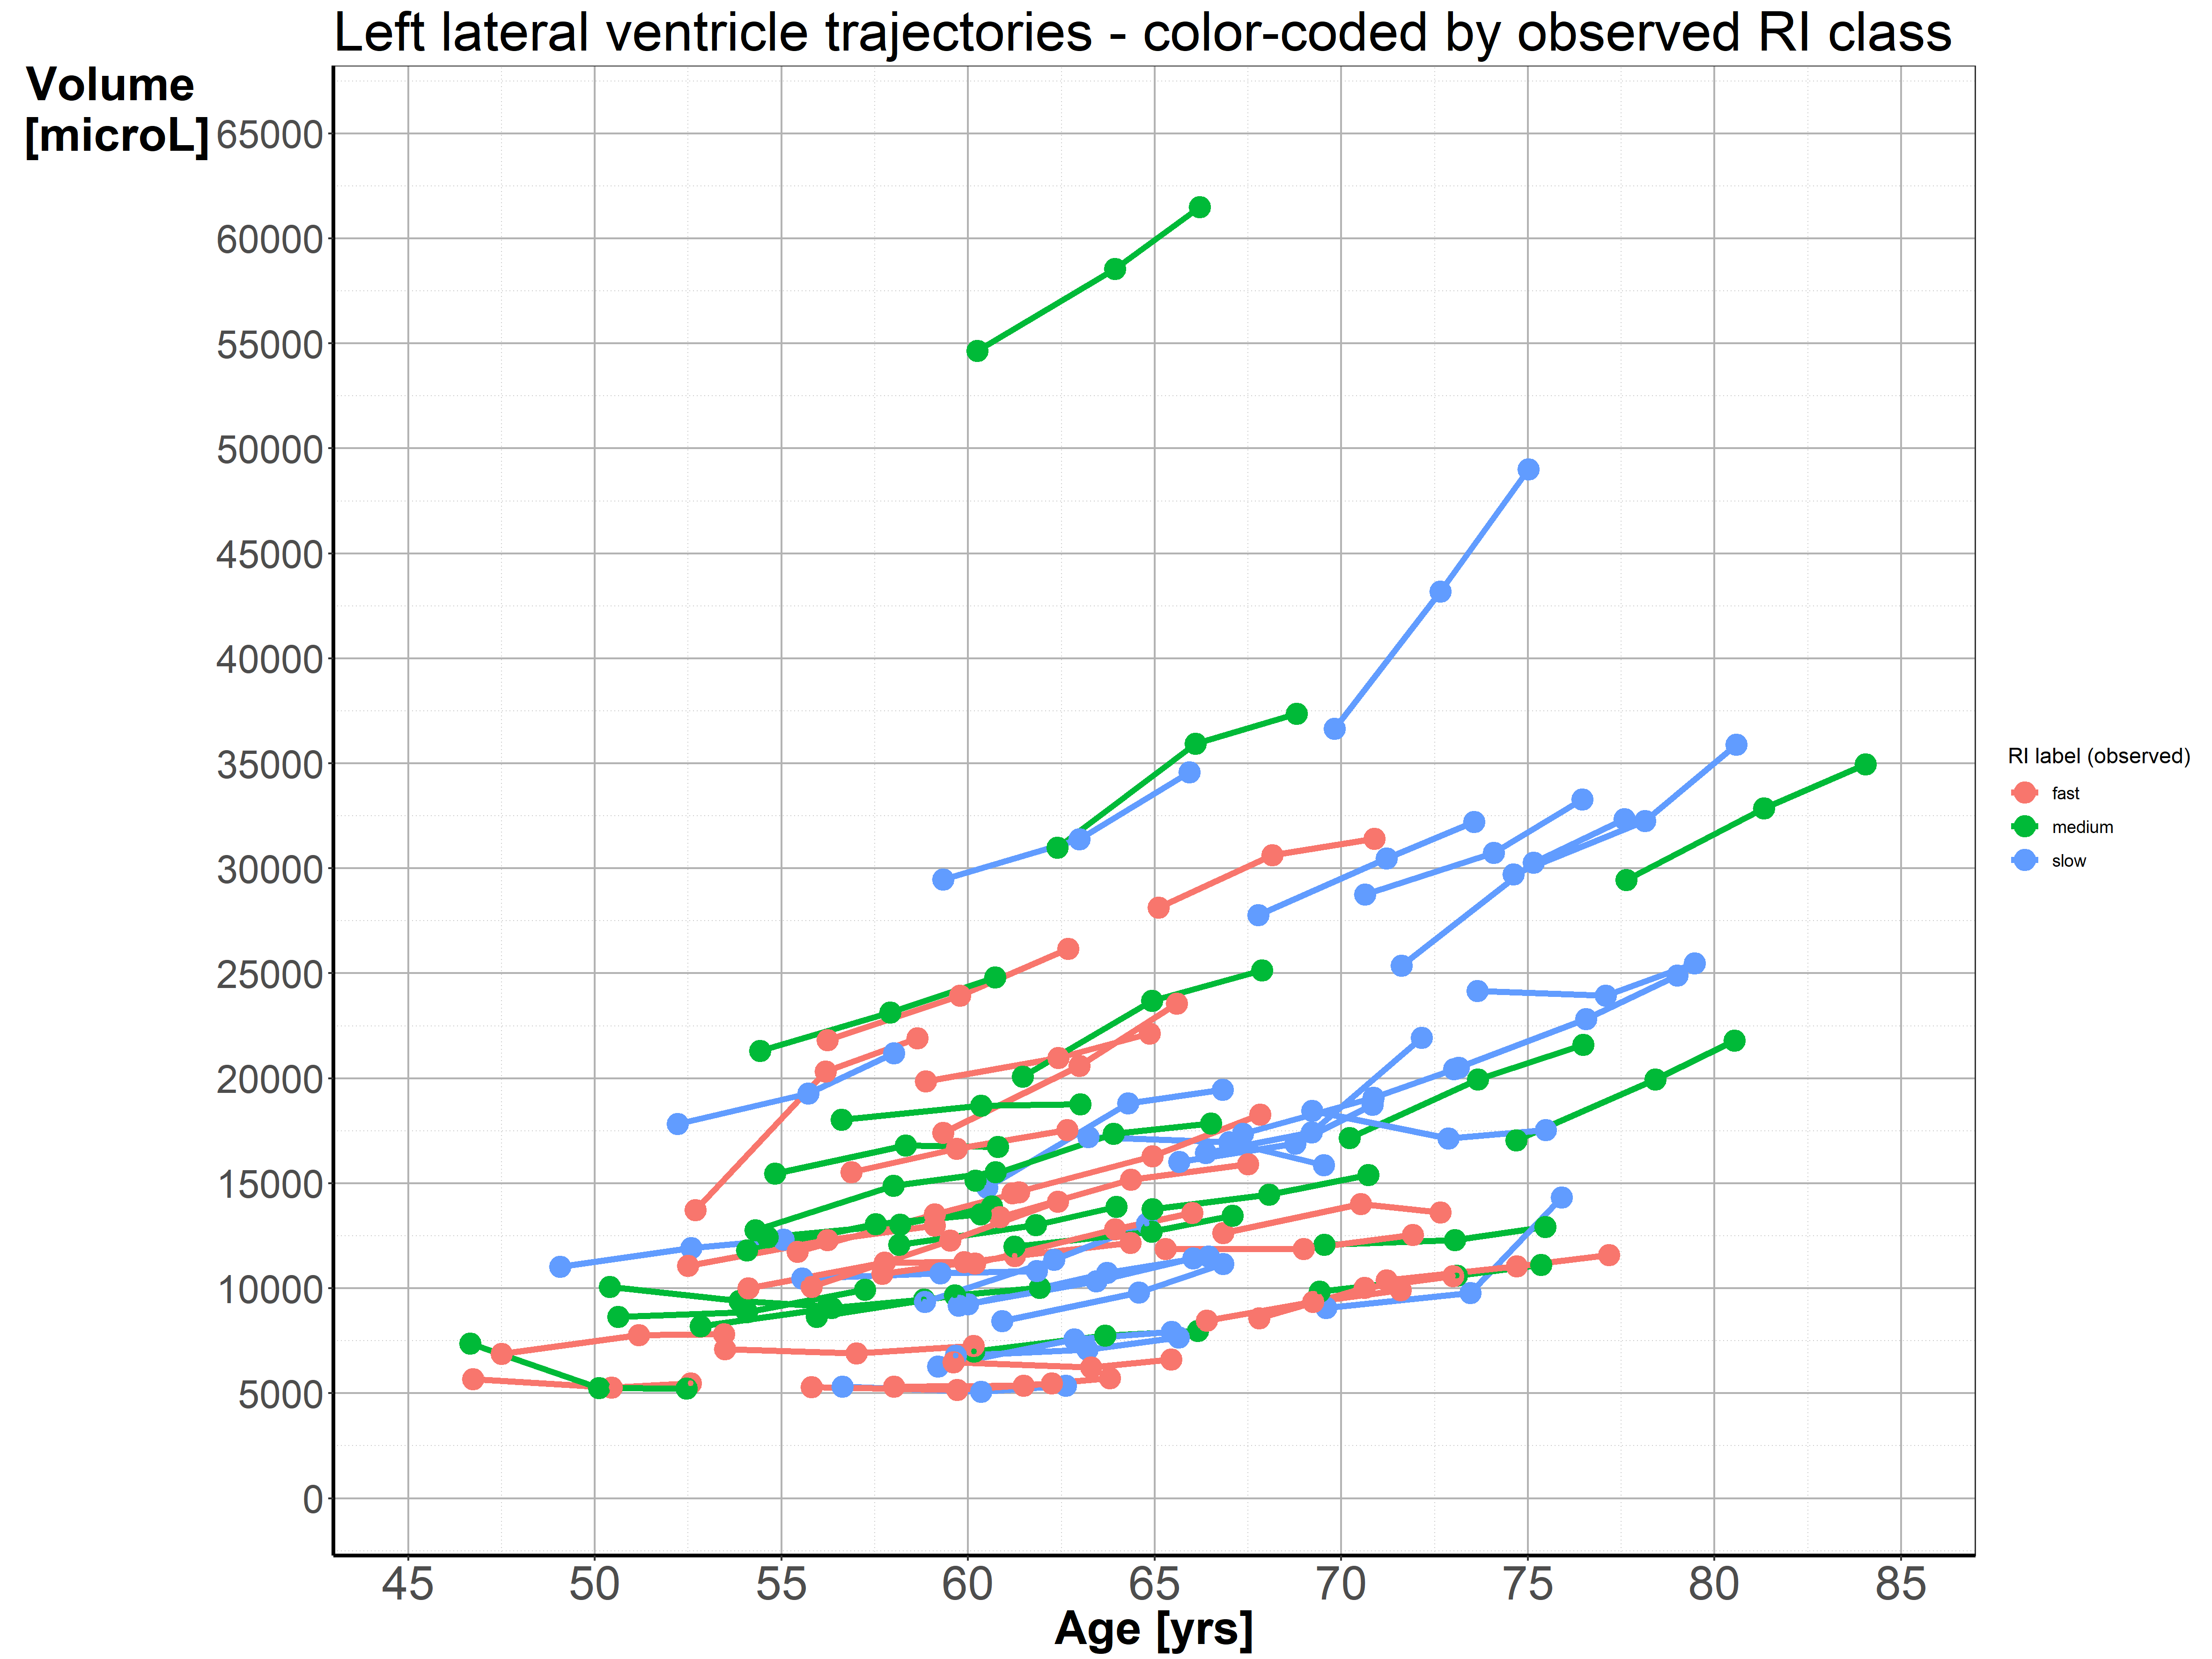

In [146]:
Image("../figures/04_lvv_ri_rpy2_LH_by_RI_obs.png", width=900)

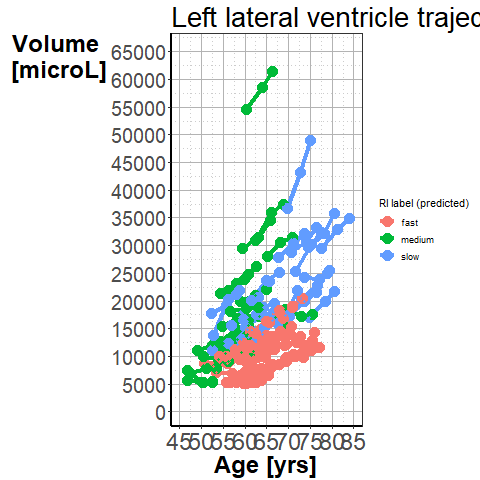

In [147]:
%%R -i dfLg -i eTIV_NORMALIZED

NOR <- eTIV_NORMALIZED

# Left lateral ventricle

if (NOR) {
title.1.L <- "Left lateral ventricle (eTIV normalized)"
} else {
RdfLg <-  dfLg

title.1.L <- "Left lateral ventricle trajectories - color-coded by predicted RI class"

mytitle <- title.1.L

g11 <- ggplot(data = RdfLg, aes(x = Age, y = Volume, group = Subject, colour = factor(RI_pred))) + geom_line(size=1.5)
g11 <- g11 + scale_colour_discrete(name  ="RI label (predicted)") + geom_point(pch=19, size = 5)
myX <- scale_x_continuous(limits = c(45, 85), breaks = seq(45, 85, 5), name = "Age [yrs]")
myY <- scale_y_continuous(limits = c(500, 65000), breaks = seq(0, 65000, 5000), name = "Volume\n [microL]") 

g11 <- g11 + geom_point(size = 1.0) + theme_bw() + myX + myY
g11 <- g11 + labs(title = mytitle, fontsize = 32)
# Set title to twice the base font size
g11 <- g11 + theme(plot.title = element_text(size = rel(2.0)))
g11 <- g11 + theme(axis.line = element_line(size = 1, colour = "black", linetype = "solid"))
g11 <- g11 + theme(axis.text = element_text(size = rel(1.5)))
g11 <- g11 + theme(axis.title.y = element_text(size = rel(1.8), angle = 0))
g11 <- g11 + theme(axis.title.x = element_text(size = rel(1.8), angle = 0))
g11 <- g11 + theme(panel.grid.major = element_line(colour = "gray70"))
g11 <- g11 + theme(panel.grid.minor = element_line(colour = "gray80", linetype = "dotted"))
g11 <- g11 + theme(plot.background = element_rect(fill = "white"))

g11 <- g11 + theme(axis.text.x=element_text(size=24), axis.title.x=element_text(size=24,face="bold"))
g11 <- g11 + theme(axis.text.y=element_text(size=20), axis.title.y=element_text(size=24,face="bold"))
g11 <- g11 + theme(plot.title = element_text(size=28))

print(g11)
    
ggsave("../figures/04_lvv_ri_rpy2_LH_by_RI_pred.pdf", width = 40, height = 30, units = "cm")
ggsave("../figures/04_lvv_ri_rpy2_LH_by_RI_pred.png", width = 40, height = 30, units = "cm")
}

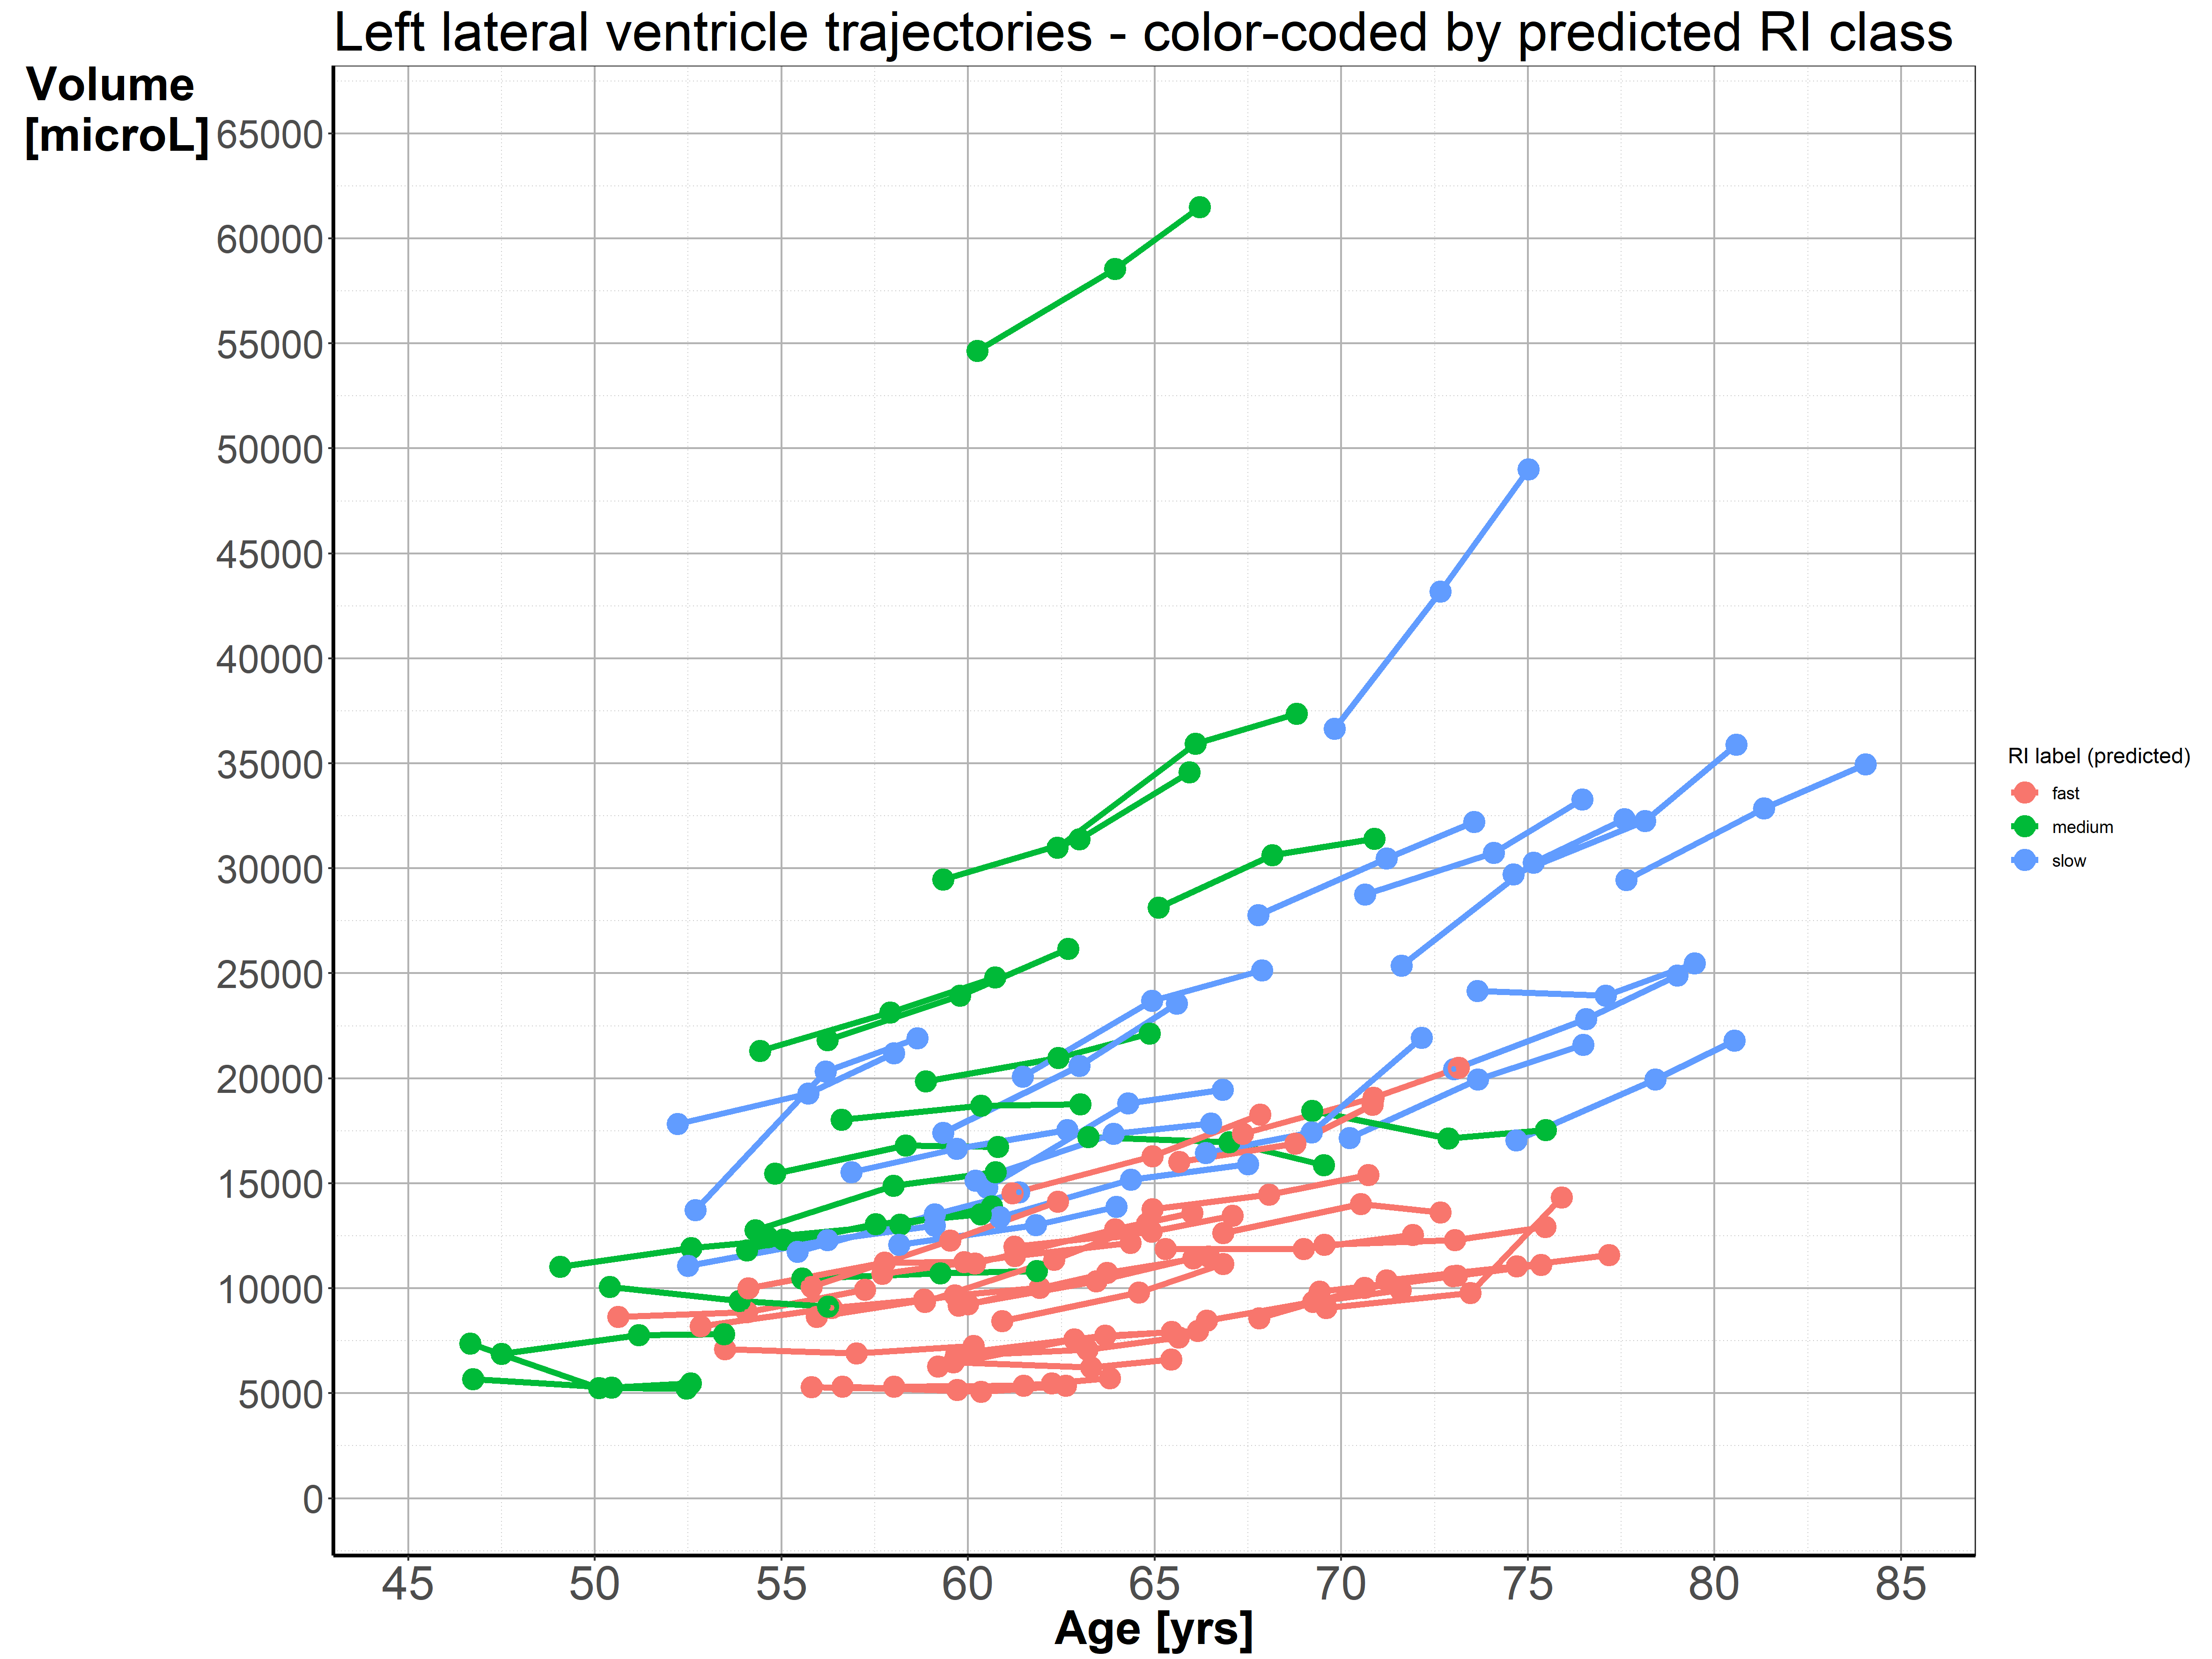

In [148]:
Image("../figures/04_lvv_ri_rpy2_LH_by_RI_pred.png", width=900)

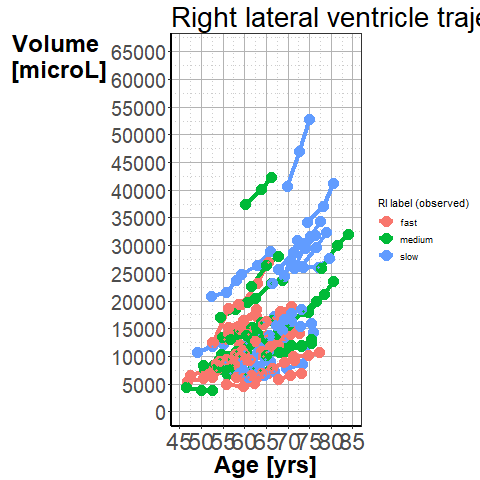

In [149]:
%%R -i dfRg -i eTIV_NORMALIZED

NOR <- eTIV_NORMALIZED

# Right lateral ventricle

if (NOR) {
title.1.L <- "Right lateral ventricle (eTIV normalized)"
} else {
RdfRg <-  dfRg

title.1.L <- "Right lateral ventricle trajectories - color-coded by observed RI class"

mytitle <- title.1.L

g11 <- ggplot(data = RdfRg, aes(x = Age, y = Volume, group = Subject, colour = factor(RI_obs))) + geom_line(size=1.5)
g11 <- g11 + scale_colour_discrete(name  ="RI label (observed)") + geom_point(pch=19, size = 5)
myX <- scale_x_continuous(limits = c(45, 85), breaks = seq(45, 85, 5), name = "Age [yrs]")
myY <- scale_y_continuous(limits = c(500, 65000), breaks = seq(0, 65000, 5000), name = "Volume\n [microL]") 

g11 <- g11 + geom_point(size = 1.0) + theme_bw() + myX + myY
g11 <- g11 + labs(title = mytitle, fontsize = 32)
# Set title to twice the base font size
g11 <- g11 + theme(plot.title = element_text(size = rel(2.0)))
g11 <- g11 + theme(axis.line = element_line(size = 1, colour = "black", linetype = "solid"))
g11 <- g11 + theme(axis.text = element_text(size = rel(1.5)))
g11 <- g11 + theme(axis.title.y = element_text(size = rel(1.8), angle = 0))
g11 <- g11 + theme(axis.title.x = element_text(size = rel(1.8), angle = 0))
g11 <- g11 + theme(panel.grid.major = element_line(colour = "gray70"))
g11 <- g11 + theme(panel.grid.minor = element_line(colour = "gray80", linetype = "dotted"))
g11 <- g11 + theme(plot.background = element_rect(fill = "white"))

g11 <- g11 + theme(axis.text.x=element_text(size=24), axis.title.x=element_text(size=24,face="bold"))
g11 <- g11 + theme(axis.text.y=element_text(size=20), axis.title.y=element_text(size=24,face="bold"))
g11 <- g11 + theme(plot.title = element_text(size=28))

print(g11)
    
ggsave("../figures/04_lvv_ri_rpy2_RH_by_RI_obs.pdf", width = 40, height = 30, units = "cm")
ggsave("../figures/04_lvv_ri_rpy2_RH_by_RI_obs.png", width = 40, height = 30, units = "cm")
}

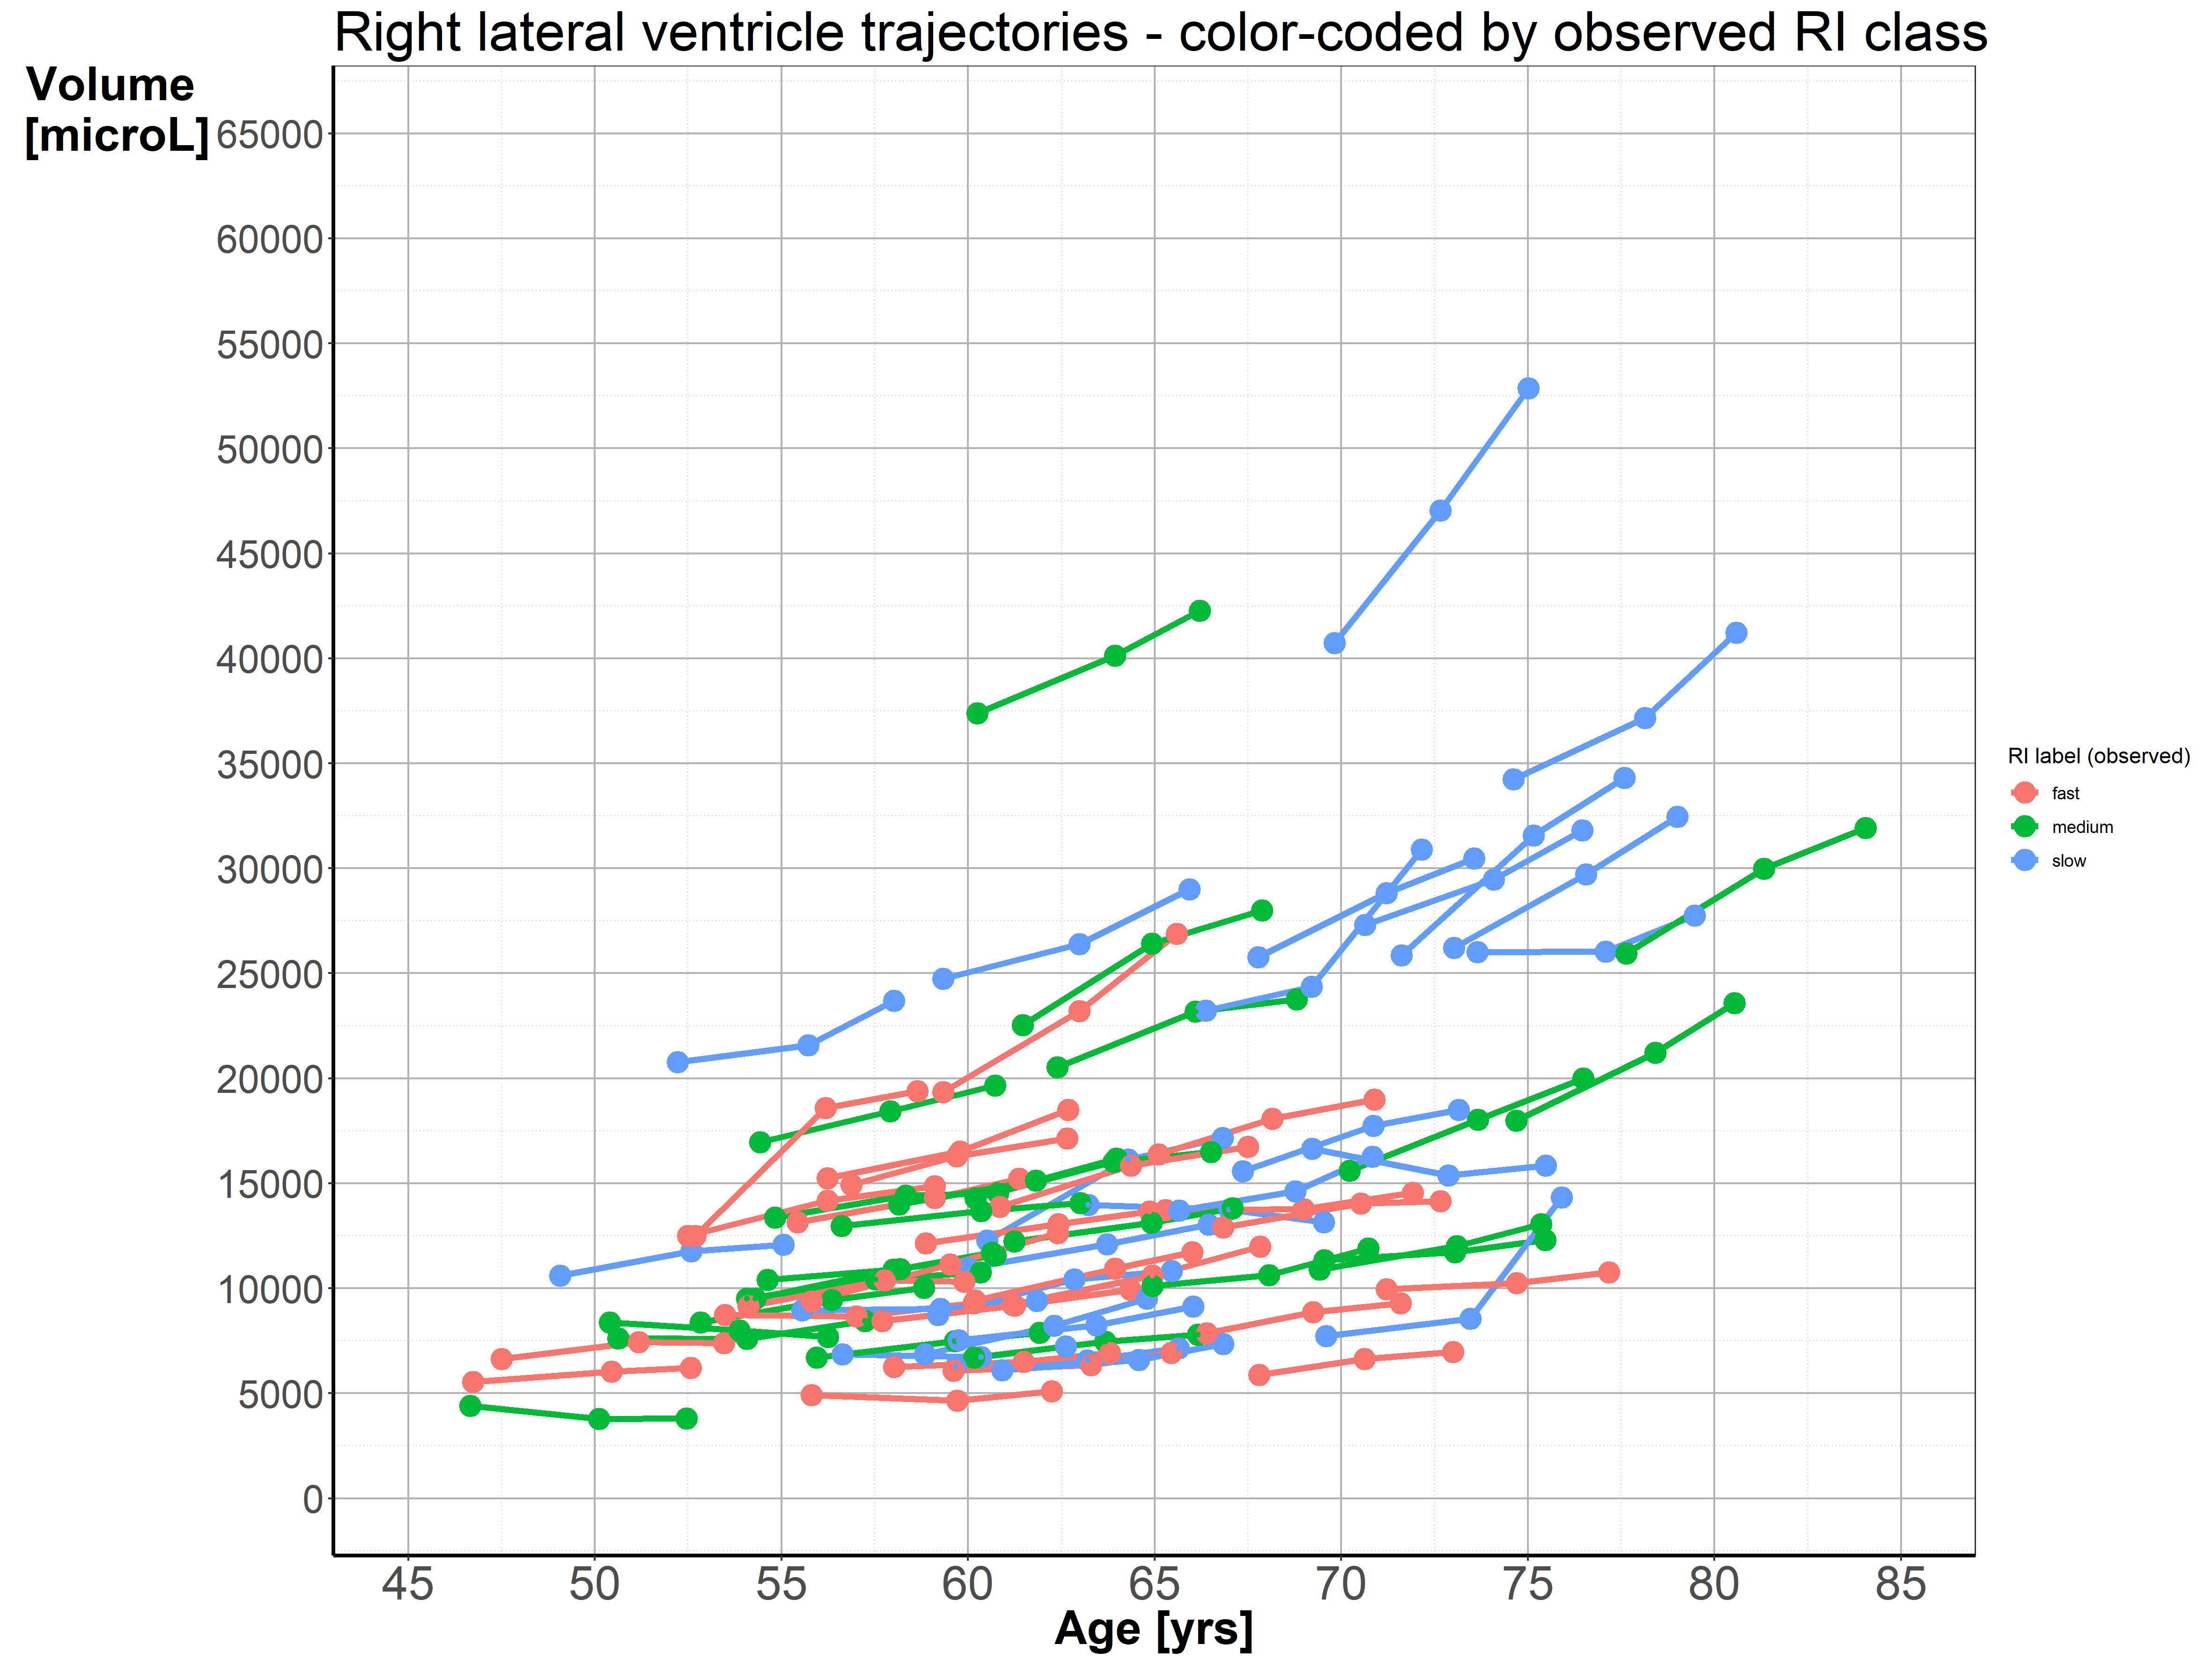

In [150]:
Image("../figures/04_lvv_ri_rpy2_RH_by_RI_obs.png", width=900)

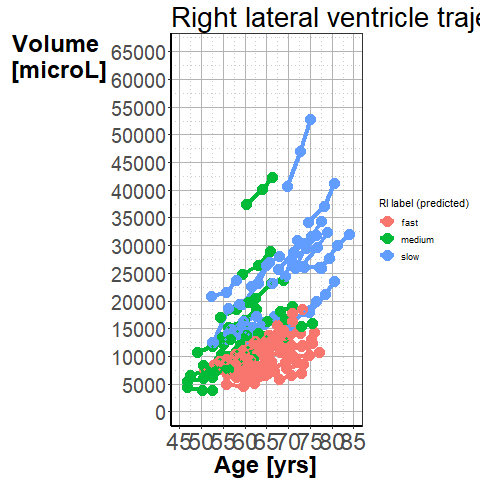

In [151]:
%%R -i dfRg -i eTIV_NORMALIZED

NOR <- eTIV_NORMALIZED

# Right lateral ventricle

if (NOR) {
title.1.L <- "Right lateral ventricle (eTIV normalized)"
} else {
RdfRg <-  dfRg

title.1.L <- "Right lateral ventricle trajectories - color-coded by predicted RI class"

mytitle <- title.1.L

g11 <- ggplot(data = RdfRg, aes(x = Age, y = Volume, group = Subject, colour = factor(RI_pred))) + geom_line(size=1.5)
g11 <- g11 + scale_colour_discrete(name  ="RI label (predicted)") + geom_point(pch=19, size = 5)
myX <- scale_x_continuous(limits = c(45, 85), breaks = seq(45, 85, 5), name = "Age [yrs]")
myY <- scale_y_continuous(limits = c(500, 65000), breaks = seq(0, 65000, 5000), name = "Volume\n [microL]") 

g11 <- g11 + geom_point(size = 1.0) + theme_bw() + myX + myY
g11 <- g11 + labs(title = mytitle, fontsize = 32)
# Set title to twice the base font size
g11 <- g11 + theme(plot.title = element_text(size = rel(2.0)))
g11 <- g11 + theme(axis.line = element_line(size = 1, colour = "black", linetype = "solid"))
g11 <- g11 + theme(axis.text = element_text(size = rel(1.5)))
g11 <- g11 + theme(axis.title.y = element_text(size = rel(1.8), angle = 0))
g11 <- g11 + theme(axis.title.x = element_text(size = rel(1.8), angle = 0))
g11 <- g11 + theme(panel.grid.major = element_line(colour = "gray70"))
g11 <- g11 + theme(panel.grid.minor = element_line(colour = "gray80", linetype = "dotted"))
g11 <- g11 + theme(plot.background = element_rect(fill = "white"))

g11 <- g11 + theme(axis.text.x=element_text(size=24), axis.title.x=element_text(size=24,face="bold"))
g11 <- g11 + theme(axis.text.y=element_text(size=20), axis.title.y=element_text(size=24,face="bold"))
g11 <- g11 + theme(plot.title = element_text(size=28))

print(g11)
    
ggsave("../figures/04_lvv_ri_rpy2_RH_by_RI_pred.pdf", width = 40, height = 30, units = "cm")
ggsave("../figures/04_lvv_ri_rpy2_RH_by_RI_pred.png", width = 40, height = 30, units = "cm")
}

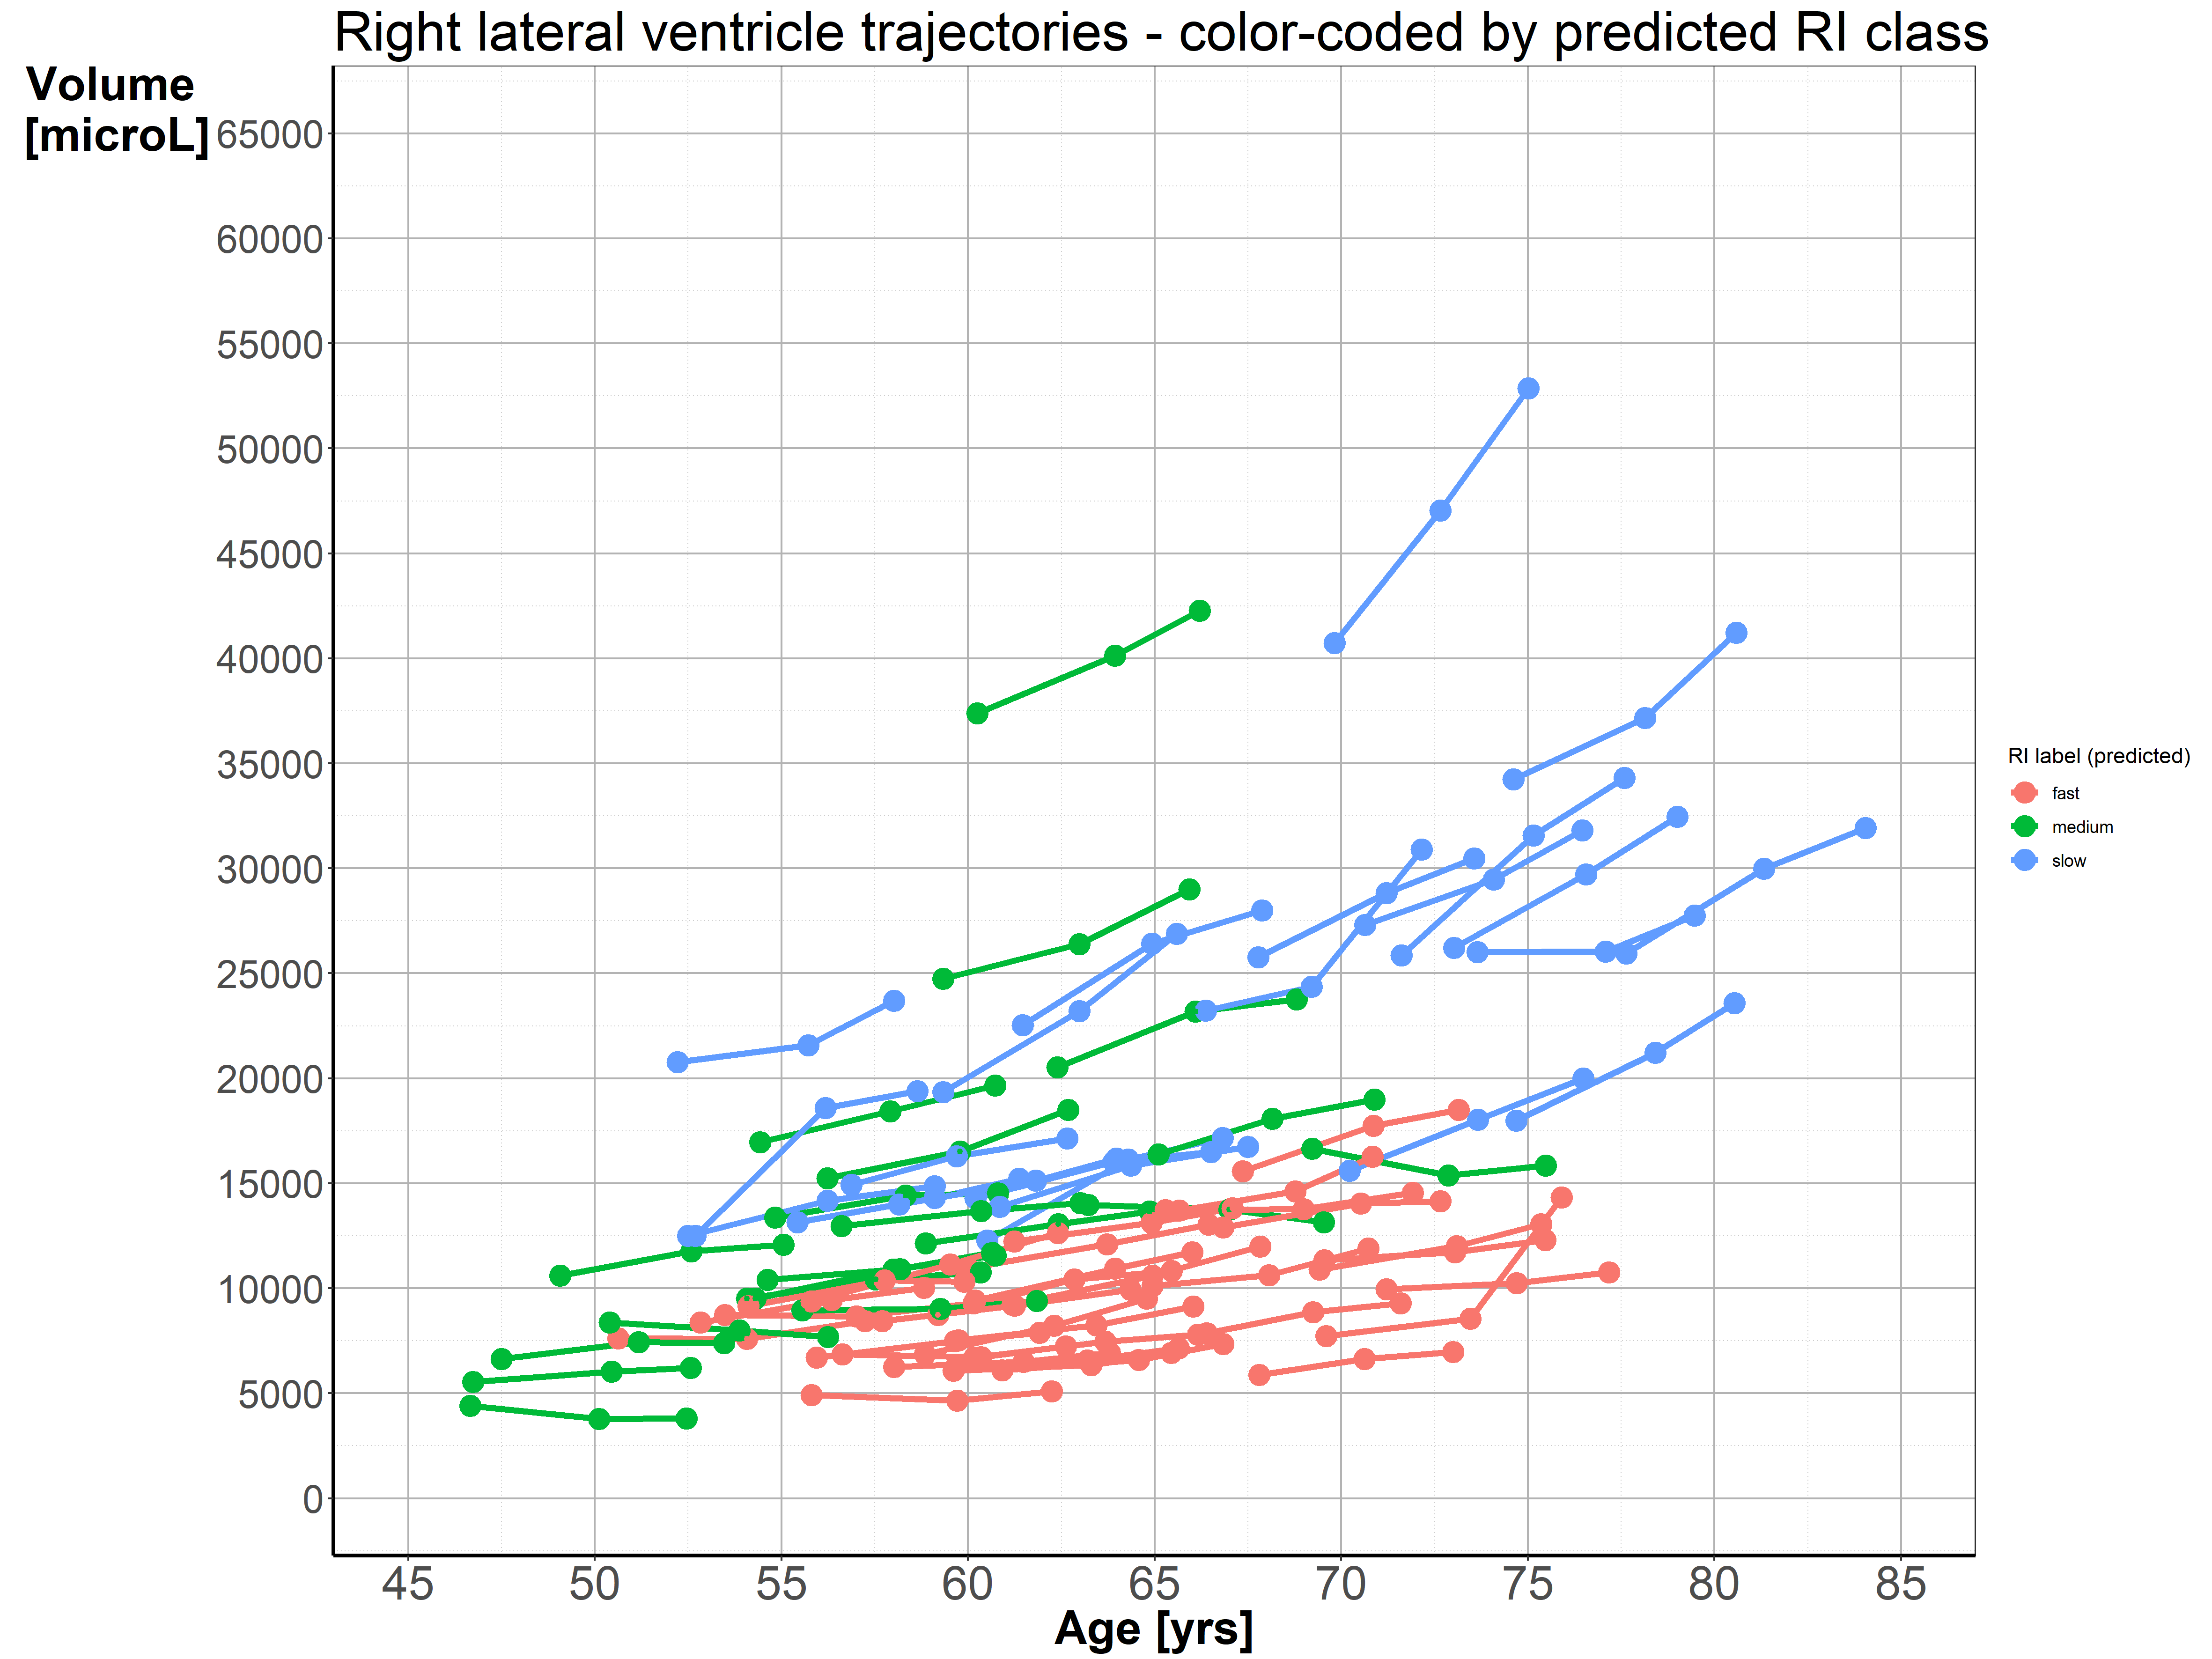

In [152]:
Image("../figures/04_lvv_ri_rpy2_RH_by_RI_pred.png", width=900)

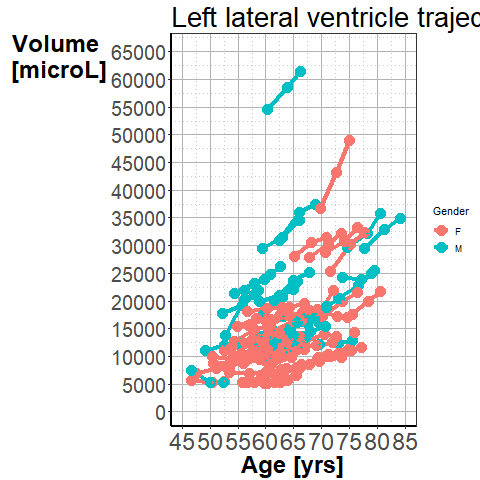

In [153]:
%%R -i dfLg -i eTIV_NORMALIZED

NOR <- eTIV_NORMALIZED

# Left lateral ventricle

if (NOR) {
title.1.L <- "Left lateral ventricle (eTIV normalized)"
} else {
RdfLg <-  dfLg

title.1.L <- "Left lateral ventricle trajectories - color-coded by gender"

mytitle <- title.1.L

g11 <- ggplot(data = RdfLg, aes(x = Age, y = Volume, group = Subject, colour = factor(Gender))) + geom_line(size=1.5)
g11 <- g11 + scale_colour_discrete(name  ="Gender") + geom_point(pch=19, size = 5)
myX <- scale_x_continuous(limits = c(45, 85), breaks = seq(45, 85, 5), name = "Age [yrs]")
myY <- scale_y_continuous(limits = c(500, 65000), breaks = seq(0, 65000, 5000), name = "Volume\n [microL]") 

g11 <- g11 + geom_point(size = 1.0) + theme_bw() + myX + myY
g11 <- g11 + labs(title = mytitle, fontsize = 32)
# Set title to twice the base font size
g11 <- g11 + theme(plot.title = element_text(size = rel(2.0)))
g11 <- g11 + theme(axis.line = element_line(size = 1, colour = "black", linetype = "solid"))
g11 <- g11 + theme(axis.text = element_text(size = rel(1.5)))
g11 <- g11 + theme(axis.title.y = element_text(size = rel(1.8), angle = 0))
g11 <- g11 + theme(axis.title.x = element_text(size = rel(1.8), angle = 0))
g11 <- g11 + theme(panel.grid.major = element_line(colour = "gray70"))
g11 <- g11 + theme(panel.grid.minor = element_line(colour = "gray80", linetype = "dotted"))
g11 <- g11 + theme(plot.background = element_rect(fill = "white"))

g11 <- g11 + theme(axis.text.x=element_text(size=24), axis.title.x=element_text(size=24,face="bold"))
g11 <- g11 + theme(axis.text.y=element_text(size=20), axis.title.y=element_text(size=24,face="bold"))
g11 <- g11 + theme(plot.title = element_text(size=28))

print(g11)
    
ggsave("../figures/04_lvv_ri_rpy2_LH_by_gender.pdf", width = 40, height = 30, units = "cm")
ggsave("../figures/04_lvv_ri_rpy2_LH_by_gender.png", width = 40, height = 30, units = "cm")
}

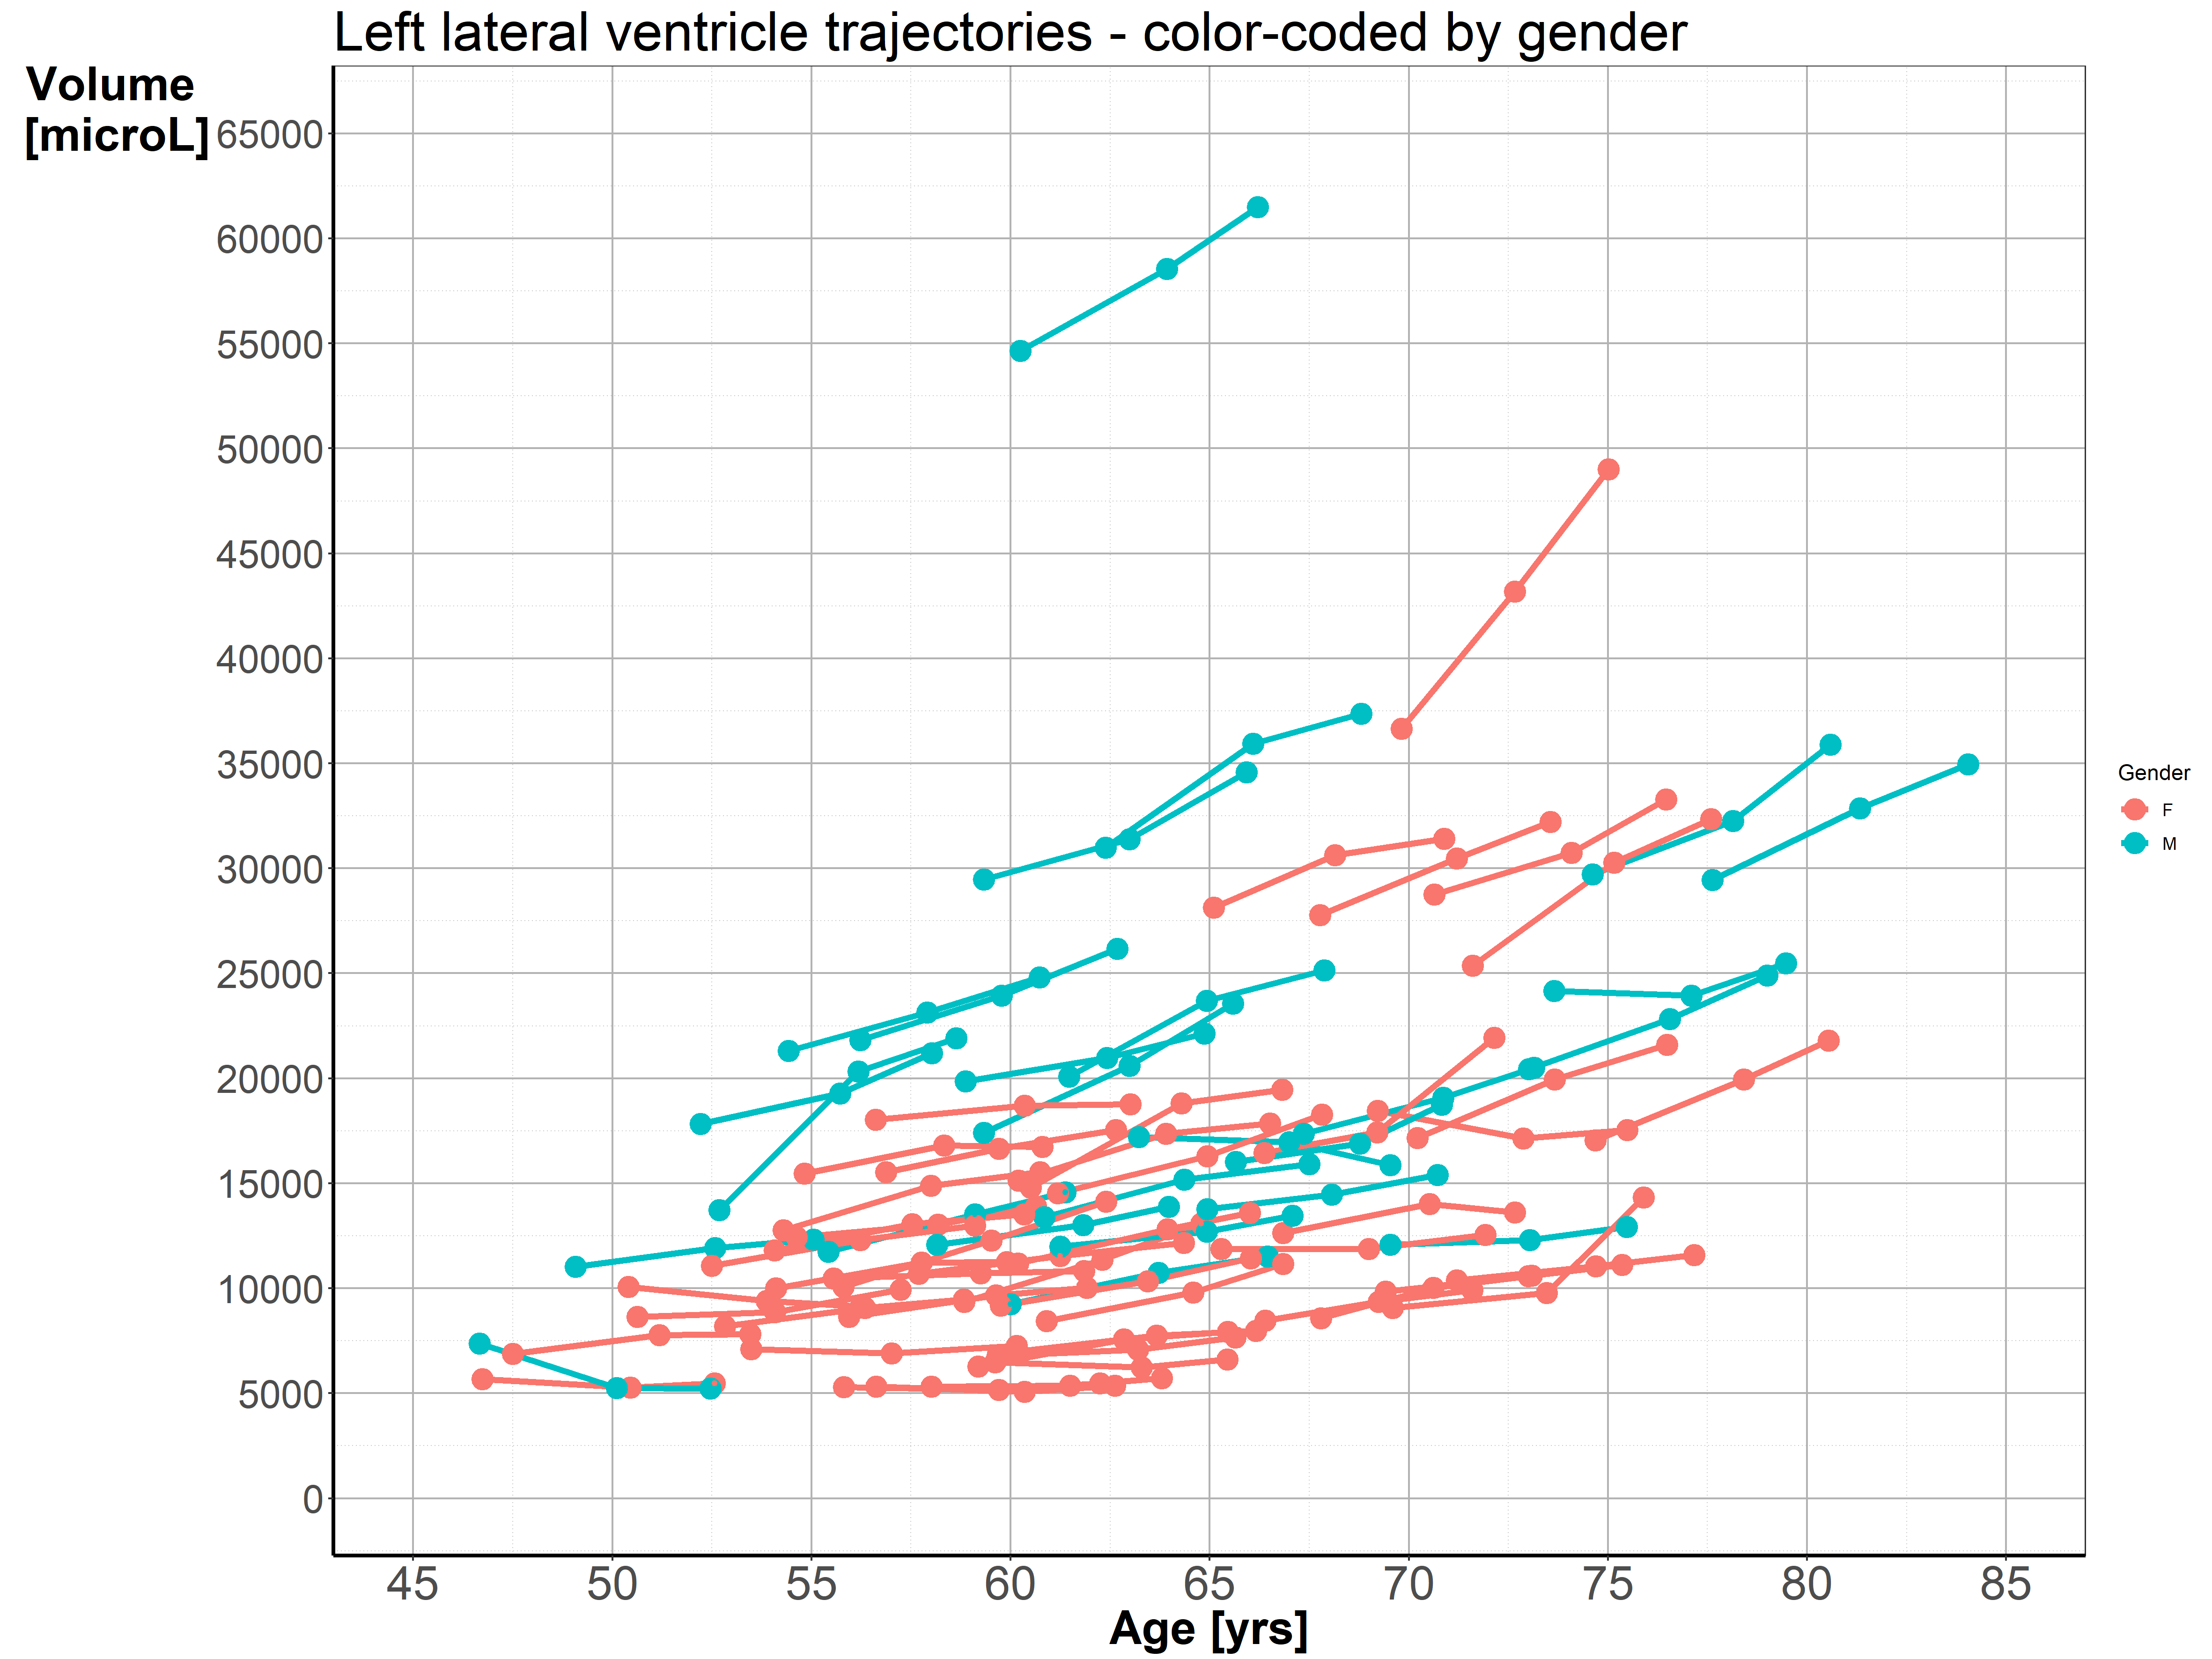

In [154]:
Image("../figures/04_lvv_ri_rpy2_LH_by_gender.png", width=900)

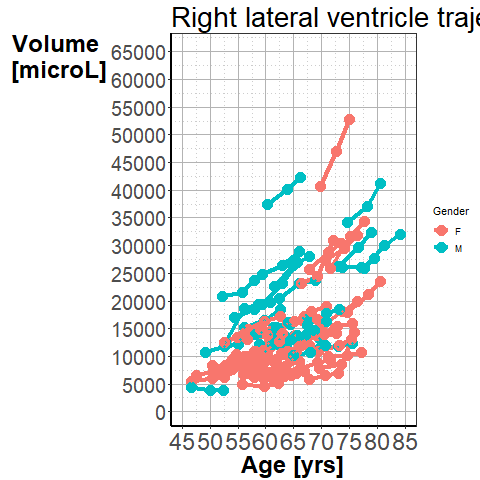

In [155]:
%%R -i dfRg -i eTIV_NORMALIZED

NOR <- eTIV_NORMALIZED

# Right lateral ventricle

if (NOR) {
title.1.L <- "Right lateral ventricle (eTIV normalized)"
} else {
RdfRg <-  dfRg

title.1.L <- "Right lateral ventricle trajectories - color-coded by gender"

mytitle <- title.1.L

g11 <- ggplot(data = RdfRg, aes(x = Age, y = Volume, group = Subject, colour = factor(Gender))) + geom_line(size=1.5)
g11 <- g11 + scale_colour_discrete(name  ="Gender") + geom_point(pch=19, size = 5)
myX <- scale_x_continuous(limits = c(45, 85), breaks = seq(45, 85, 5), name = "Age [yrs]")
myY <- scale_y_continuous(limits = c(500, 65000), breaks = seq(0, 65000, 5000), name = "Volume\n [microL]") 

g11 <- g11 + geom_point(size = 1.0) + theme_bw() + myX + myY
g11 <- g11 + labs(title = mytitle, fontsize = 32)
# Set title to twice the base font size
g11 <- g11 + theme(plot.title = element_text(size = rel(2.0)))
g11 <- g11 + theme(axis.line = element_line(size = 1, colour = "black", linetype = "solid"))
g11 <- g11 + theme(axis.text = element_text(size = rel(1.5)))
g11 <- g11 + theme(axis.title.y = element_text(size = rel(1.8), angle = 0))
g11 <- g11 + theme(axis.title.x = element_text(size = rel(1.8), angle = 0))
g11 <- g11 + theme(panel.grid.major = element_line(colour = "gray70"))
g11 <- g11 + theme(panel.grid.minor = element_line(colour = "gray80", linetype = "dotted"))
g11 <- g11 + theme(plot.background = element_rect(fill = "white"))

g11 <- g11 + theme(axis.text.x=element_text(size=24), axis.title.x=element_text(size=24,face="bold"))
g11 <- g11 + theme(axis.text.y=element_text(size=20), axis.title.y=element_text(size=24,face="bold"))
g11 <- g11 + theme(plot.title = element_text(size=28))

print(g11)
    
ggsave("../figures/04_lvv_ri_rpy2_RH_by_gender.pdf", width = 40, height = 30, units = "cm")
ggsave("../figures/04_lvv_ri_rpy2_RH_by_gender.png", width = 40, height = 30, units = "cm")
}

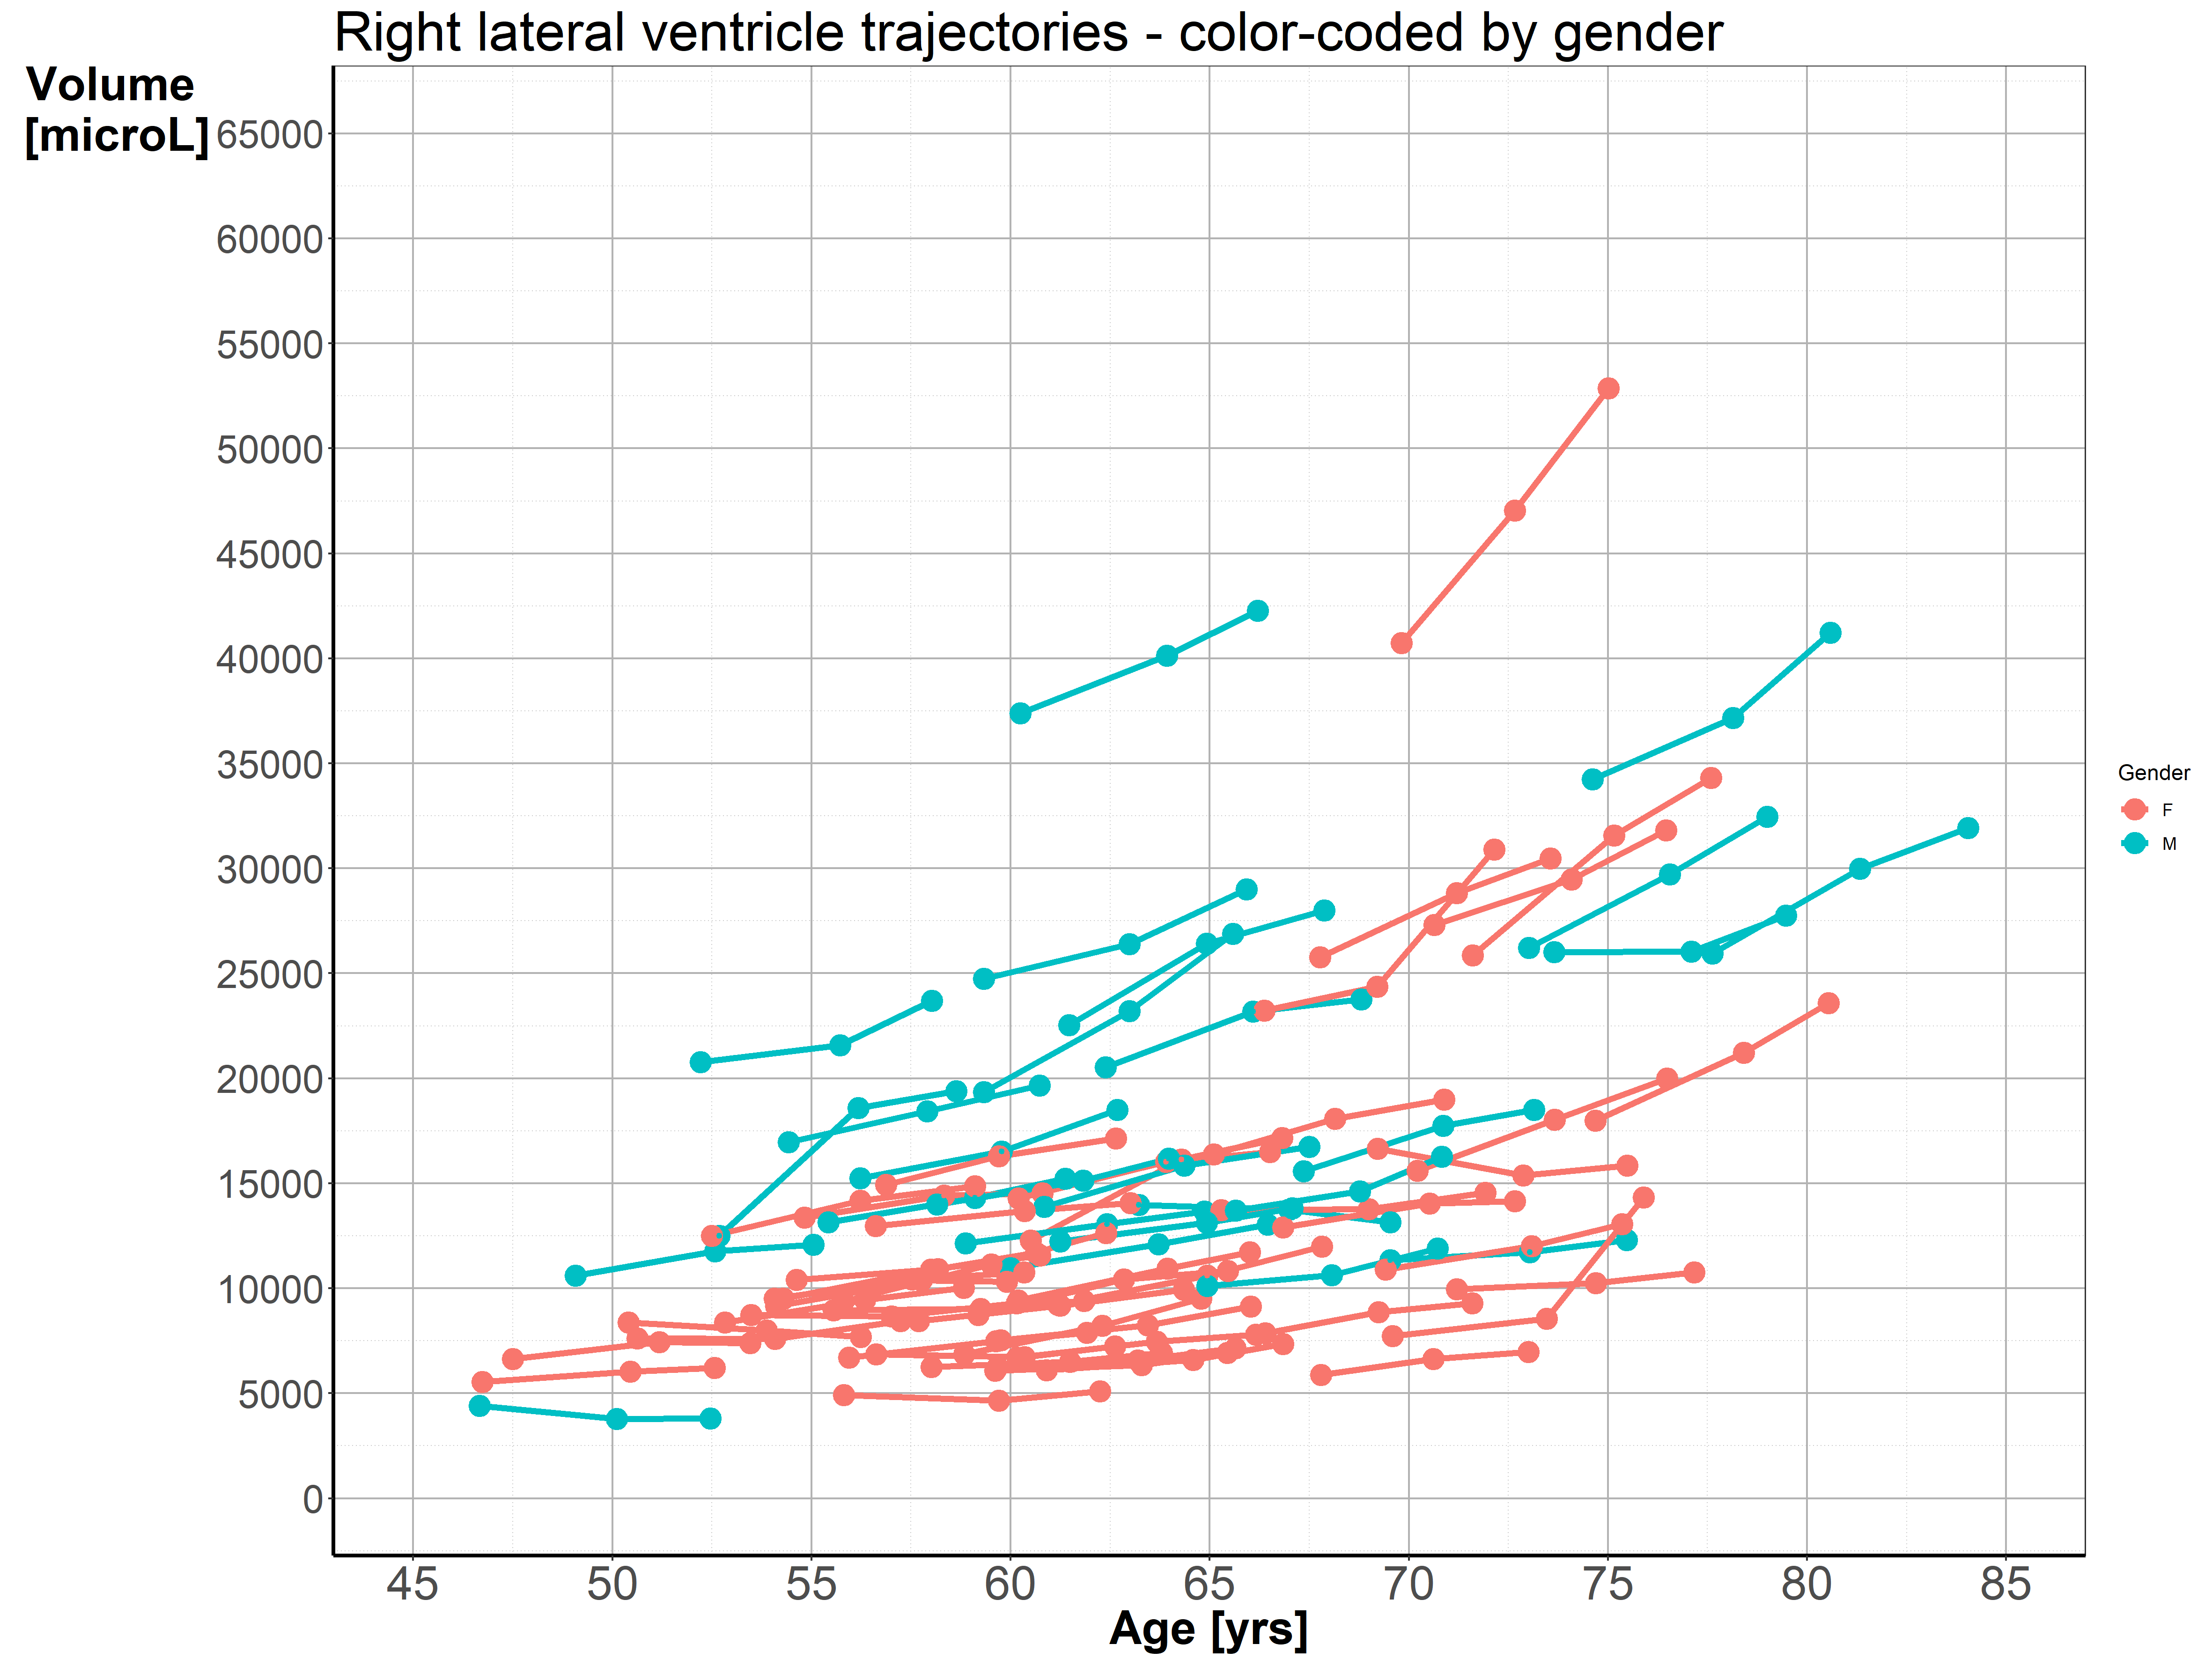

In [156]:
Image("../figures/04_lvv_ri_rpy2_RH_by_gender.png", width=900)

===========================

In [169]:
import csv
with open('../results/03_lvv_ri_lmer_feature_data_label.csv', 'rt') as f:
    data = list(csv.DictReader(f))
data[:1]

[OrderedDict([('id', '1'),
              ('Gender', 'F'),
              ('Age3', '62.62'),
              ('b1iL', '-403.143033868349'),
              ('b1iR', '-342.5619624877744'),
              ('VdevL', '-7043.60204838039'),
              ('VdevR', '-4203.292418550617'),
              ('RI3', '66.0'),
              ('RI3_label', 'slow'),
              ('RI3resid', '7.0763752610389785'),
              ('RI3resid_label', 'slow_resid')])]

## Train / test and classifications

In [171]:
from sklearn.model_selection import train_test_split

In [172]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [173]:
print(f'Training data: {X_train.shape}\nTest data: {X_test.shape}')

Treningsdata: (55, 4)
Testdata: (19, 4)


In [174]:
eli5.show_weights(perm, feature_names = X_train.columns.tolist())

Weight,Feature
0.0658 ± 0.0870,VdevL
0.0570 ± 0.0898,VdevR
0.0477 ± 0.0783,b1iR
-0.0073 ± 0.0548,b1iL


In [175]:
# Note: To avoid re-training the models when they are subject to ensembling we could have used mlextend's 
# EnsembleVoteClassifier. This will make it more time efficient.

#!pip install mlextend
#from mlxtend.classifier import EnsembleVoteClassifier
#import copy
#eclf = EnsembleVoteClassifier(clfs=[best_rs_model, gnb], weights=[1,1], refit=False)